## Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)

## Set the look of the plots

In [12]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(16,10)})
sns.set(font_scale = 2)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Import the datasets

In [4]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('test.csv')
bu_df = pd.read_csv('bu_feat.csv')

## Join the datasets

In [5]:
df = pd.merge(train_df, bu_df, on='but_num_business_unit', how='inner')

In [6]:
df['day_id'] = pd.to_datetime(df['day_id'])

In [7]:
df.head()

,day_id,but_num_business_unit,dpt_num_department,turnover,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr
0,2017-09-30,64,127,580.308443,16400,45.625172,0.111939,70,10
1,2017-09-30,119,127,1512.995918,74100,46.195037,6.254448,51,4
2,2017-09-30,4,88,668.593556,6600,43.600994,7.078160,55,10
3,2017-09-30,425,127,0.000000,59000,50.617921,3.084186,33,3
4,2017-09-30,513,73,0.000000,33610,44.717366,-0.733429,33,3


## Visual EDA

### 1. Turnover in General
__Insights:__ 
1.  There seems to be an indication that there are winter and summer peaks in turnover. Also, 2016 was much better than the previous years, but then 2017 turnover lowered and is comparable to 2012-2015

In [8]:
df.isnull().sum()

day_id                   0
but_num_business_unit    0
dpt_num_department       0
turnover                 0
but_postcode             0
but_latitude             0
but_longitude            0
but_region_idr_region    0
zod_idr_zone_dgr         0
dtype: int64

In [9]:
df.columns

Index(['day_id', 'but_num_business_unit', 'dpt_num_department', 'turnover',
       'but_postcode', 'but_latitude', 'but_longitude',
       'but_region_idr_region', 'zod_idr_zone_dgr'],
      dtype='object')

#### 1.1. Let's see how turnover behaves over time for all stores and departments

Text(0.5, 1.0, 'Turnover by Date')

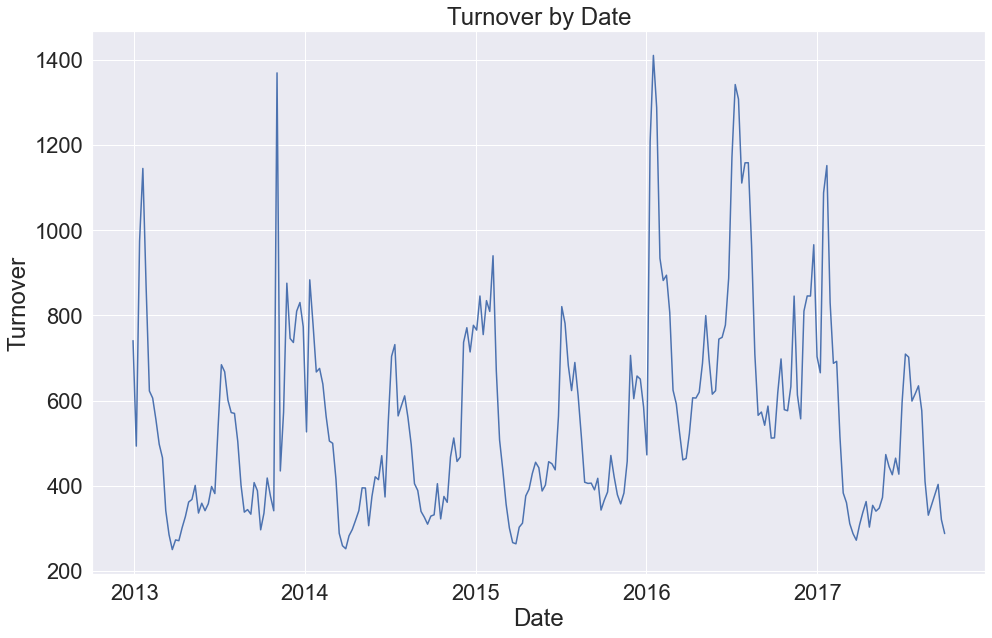

In [13]:
sns.lineplot(data=df, x='day_id', y='turnover', errorbar=None)
plt.xlabel('Date')  
plt.ylabel('Turnover')
plt.title('Turnover by Date')

#### 1.2. Let's see how turnover behaves over time for all stores but broken down by month

In [14]:
df['year'] = df['day_id'].dt.year
df['month'] = df['day_id'].dt.month
df['week'] = df['day_id'].dt.isocalendar().week 
df['quarter'] = df['day_id'].dt.quarter

In [15]:
## We need to sum the turnover by month of each year so we can build the chart
df_by_month = df.groupby(['month', 'year'], as_index=False)['turnover'].sum().reset_index()

In [16]:
df_by_month.head()

,index,month,year,turnover
0,0,1,2013,3.572216e+06
1,1,1,2014,3.022784e+06
2,2,1,2015,4.301633e+06
3,3,1,2016,5.855704e+06
4,4,1,2017,4.576360e+06


In [17]:
# Map month numbers to month names so the chart looks more informative
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

df_by_month['month_name'] = df_by_month['month'].map(month_names)

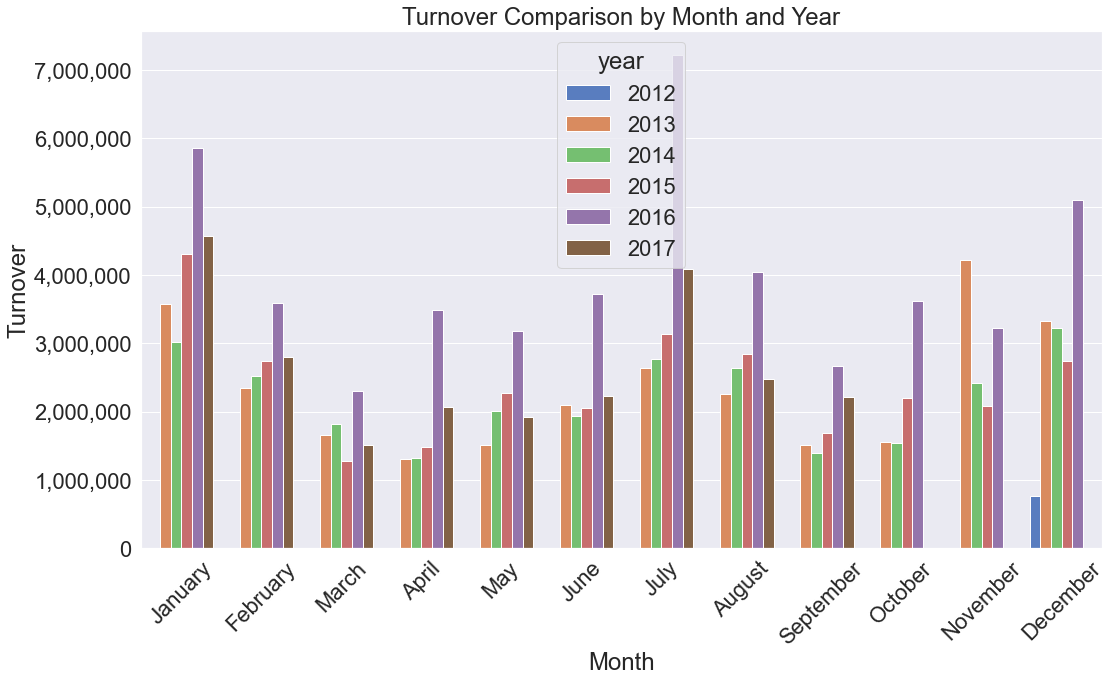

In [18]:
# Plotting barplots for each month
sns.barplot(x='month_name', y='turnover', hue='year', data=df_by_month, palette="muted")

# Customize the plot
plt.title('Turnover Comparison by Month and Year')
plt.xlabel('Month')
plt.ylabel('Turnover')
#plt.legend(title='Year', loc='upper right', fontsize='small')

def format_func(value, tick_number): ## this makes the y axis return the actual values of turnover
    return f'{int(value):,}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.xticks(rotation=45) 

plt.tight_layout()
plt.show()

#### 1.3. Let's see the changes for each month year by year

In [19]:
## For example, was there a decrease or an increase from January 2012 to January 2013, from January 2013 to January 2014, etc.

In [20]:
# Calculate year-over-year percentage changes for each month
df_by_month['turnover_change_pct'] = df_by_month.groupby('month_name')['turnover'].pct_change() * 100

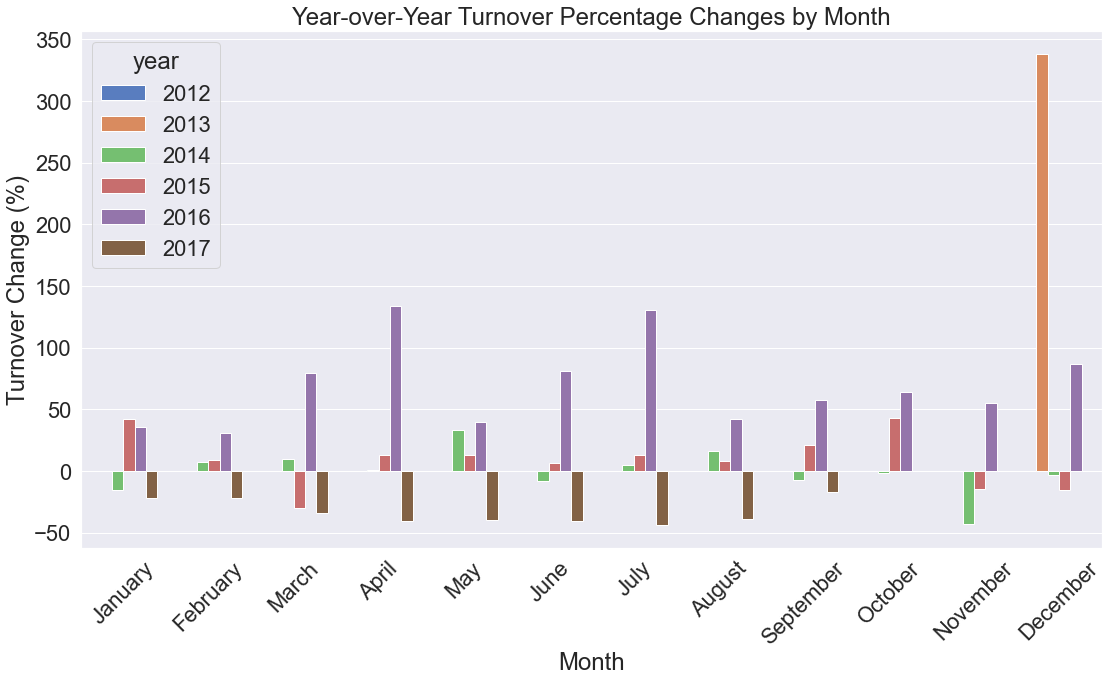

In [21]:
# Plotting barplots for turnover percentage changes between years for each month
sns.barplot(x='month_name', y='turnover_change_pct', hue='year', data=df_by_month, palette="muted")

# Customize the plot
plt.title('Year-over-Year Turnover Percentage Changes by Month')
plt.xlabel('Month')
plt.ylabel('Turnover Change (%)')

plt.xticks(rotation=45)  

plt.tight_layout()
plt.show()

#### 1.4. Let's see how revenue changes each week for each year

In [22]:
## We need to sum the turnover by week of each year so we can build the chart
df_by_week = df.groupby(['year', 'week'], as_index=False)['turnover'].sum().reset_index()

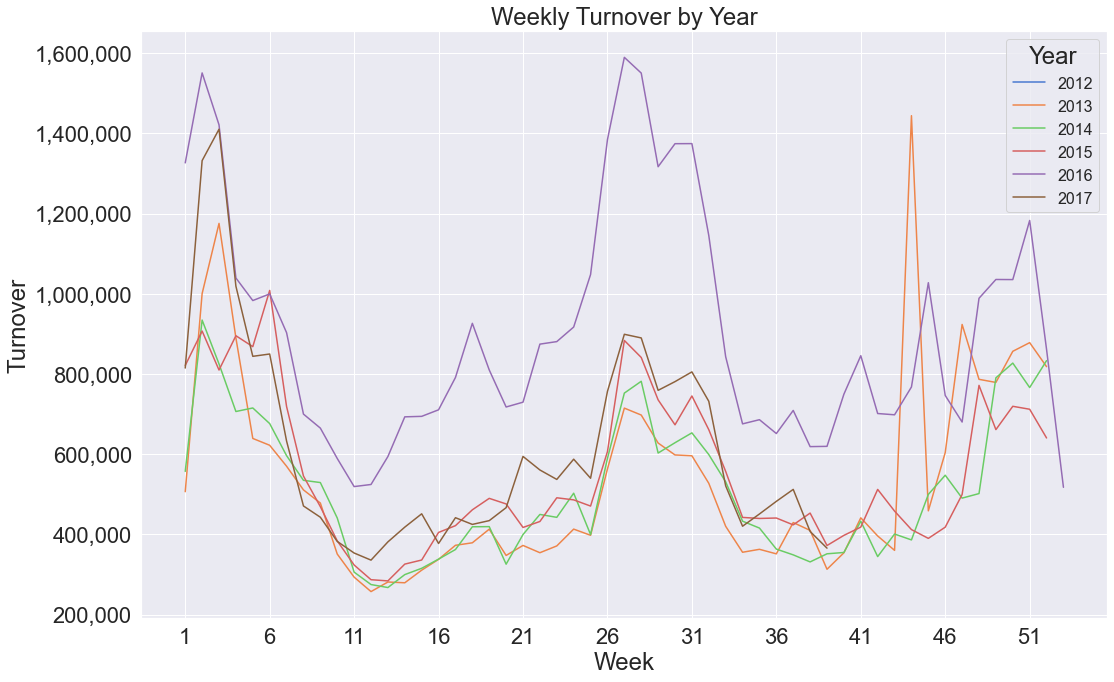

In [23]:
sns.lineplot(x='week', y='turnover', data=df_by_week, hue = 'year', palette="muted")

plt.title('Weekly Turnover by Year')
plt.xlabel('Week')
plt.ylabel('Turnover')
plt.legend(title='Year', loc='upper right', fontsize=16)

# this is defined in chart 1.2.
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

# Set x-axis ticks at 5-week intervals
plt.xticks(ticks=range(1, df_by_week['week'].max(), 5))

plt.tight_layout()
plt.show()

### 2. Turnover by Department

__Insights:__ 
1.  Departments 73 and 88 have relatively less turnover than departments 117 and 127. This makes the charts less informative than they should be, so we can plot them separately to see how turnover behaves over time.
2.  Departments 117 and 127 have different seasonalities
3.  There seems to be an outlier for Department 88. We can conclude this is an outlier because most of the turnover for department 88 is up to 1000

#### 2.1. Let's see how turnover behaves over time per department

Text(0.5, 1.0, 'Turnover by Date')

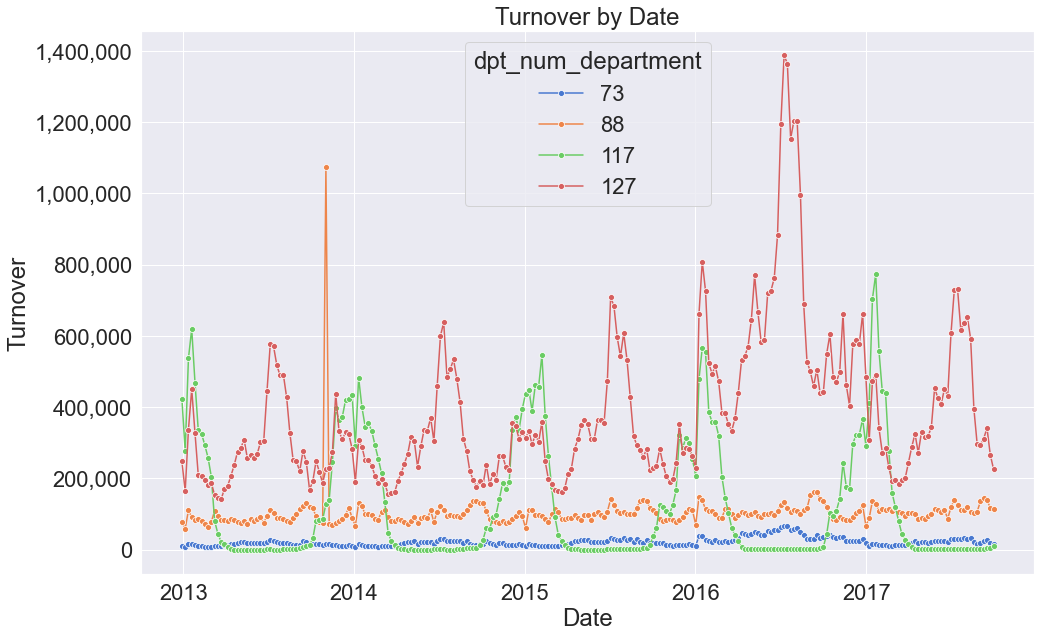

In [24]:
sns.lineplot(x='day_id', y='turnover', hue='dpt_num_department', data=df, marker='o', estimator=sum, errorbar=None, palette="muted")
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.xlabel('Date')  
plt.ylabel('Turnover')
plt.title('Turnover by Date')

##### 2.1.2. Let's remove the smaller turnover departments and plot them separately

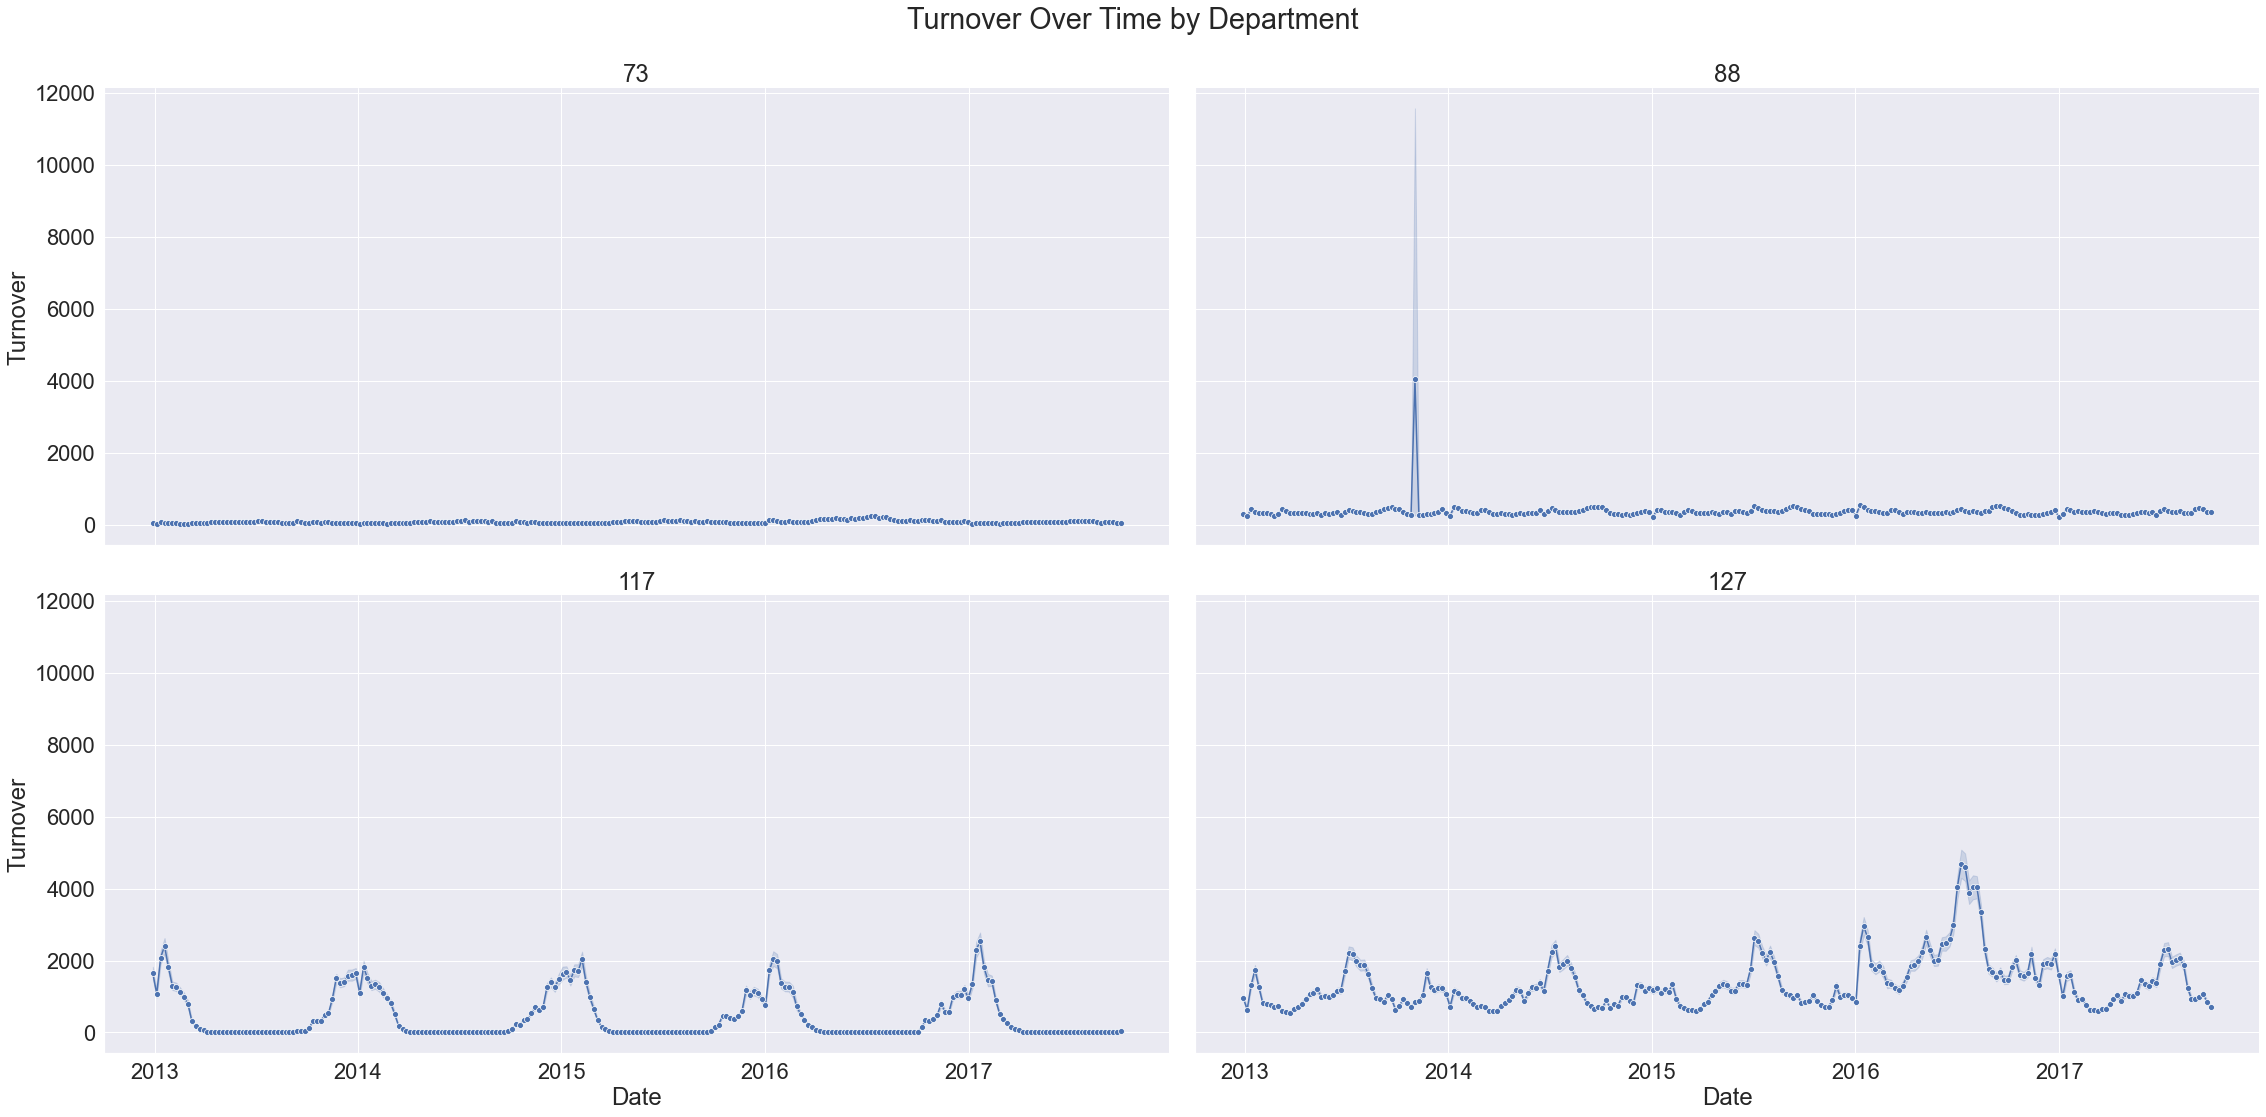

In [25]:
# Create a FacetGrid for each department
g = sns.FacetGrid(df, col='dpt_num_department', col_wrap=2, height=8, aspect=2)
g.map_dataframe(sns.lineplot, x='day_id', y='turnover', marker='o')

# Customize the plots
g.set_titles('{col_name}')
g.set_xlabels('Date')
g.set_ylabels('Turnover')
g.fig.suptitle('Turnover Over Time by Department')

plt.tight_layout()
plt.show()

##### 2.1.3. Let's plot each department separately

Text(0.5, 1.0, 'Turnover by Date for Department 73')

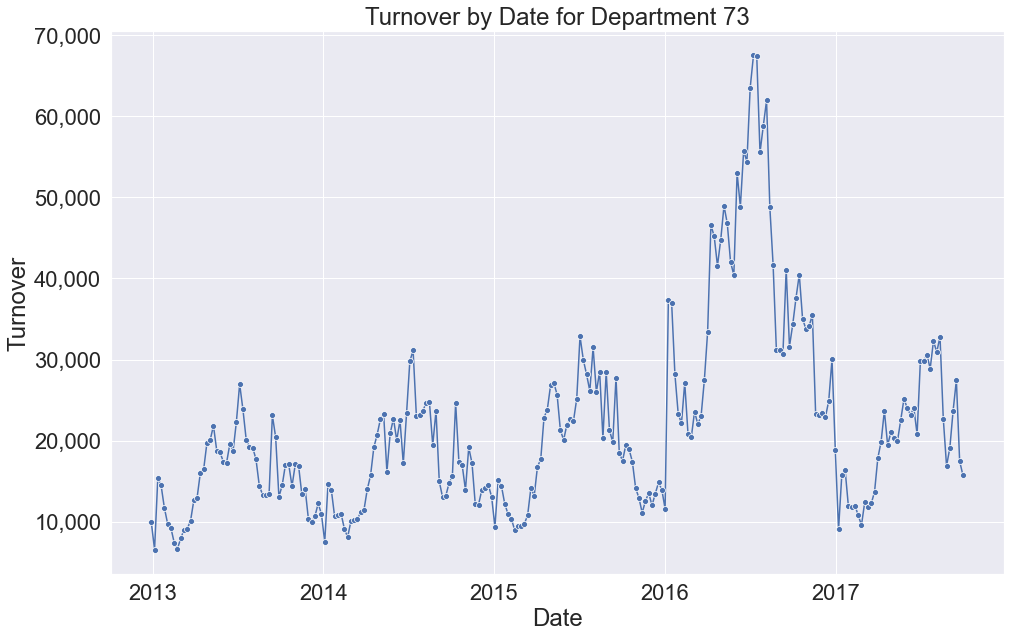

In [26]:
sns.lineplot(x='day_id', y='turnover', data=df[df['dpt_num_department'] == 73], marker='o', estimator=sum, errorbar=None)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.xlabel('Date')  
plt.ylabel('Turnover')
plt.title('Turnover by Date for Department 73')

Text(0.5, 1.0, 'Turnover by Date for Department 88')

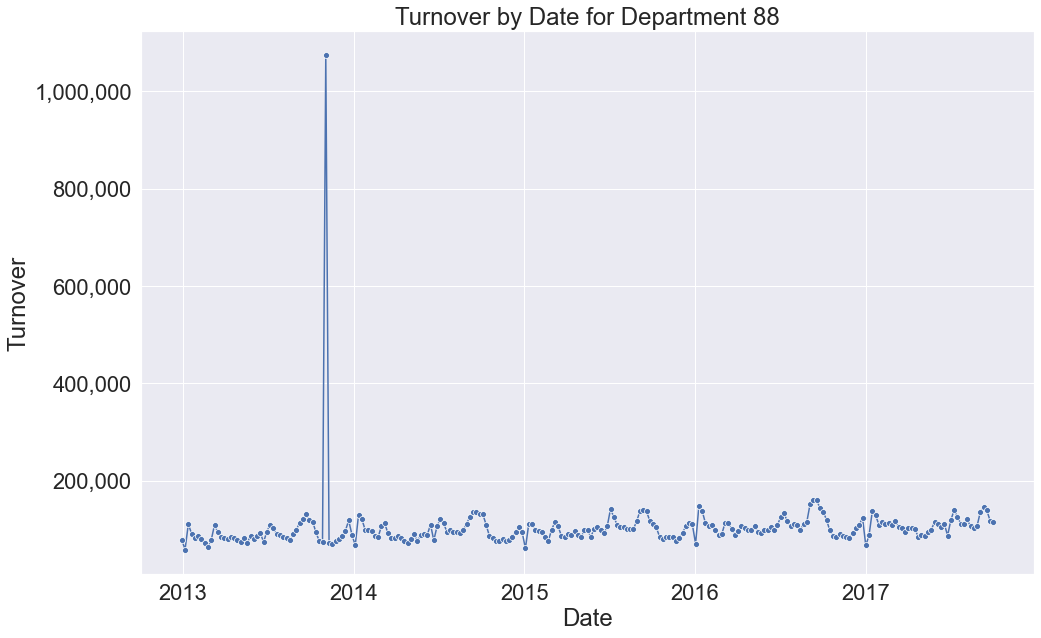

In [27]:
sns.lineplot(x='day_id', y='turnover', data=df[df['dpt_num_department'] == 88], marker='o', estimator=sum, errorbar=None)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.xlabel('Date')  
plt.ylabel('Turnover')
plt.title('Turnover by Date for Department 88')

##### 2.1.4. Outlier Check for Department 88

In [28]:
df[(df['dpt_num_department'] == 88) & (df['turnover'] > 200000)]

,day_id,but_num_business_unit,dpt_num_department,turnover,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr,year,month,week,quarter
231272,2013-11-02,30,88,1000000.0,38700,45.197547,5.750372,52,4,2013,11,44,4


In [29]:
## these are the stats for department 88 with the outlier
df[df['dpt_num_department'] == 88]['turnover'].describe()

count      70230.000000
mean         368.750124
std         3780.896322
min           -6.896619
25%          175.832958
50%          300.590220
75%          476.785353
max      1000000.000000
Name: turnover, dtype: float64

In [30]:
## these are the stats for department 88 without the outlier
df[(df['dpt_num_department'] == 88) & (df['turnover'] < 1000000)]['turnover'].describe()

count    70229.000000
mean       354.516242
std        257.570924
min         -6.896619
25%        175.832958
50%        300.583888
75%        476.785114
max       2310.891705
Name: turnover, dtype: float64

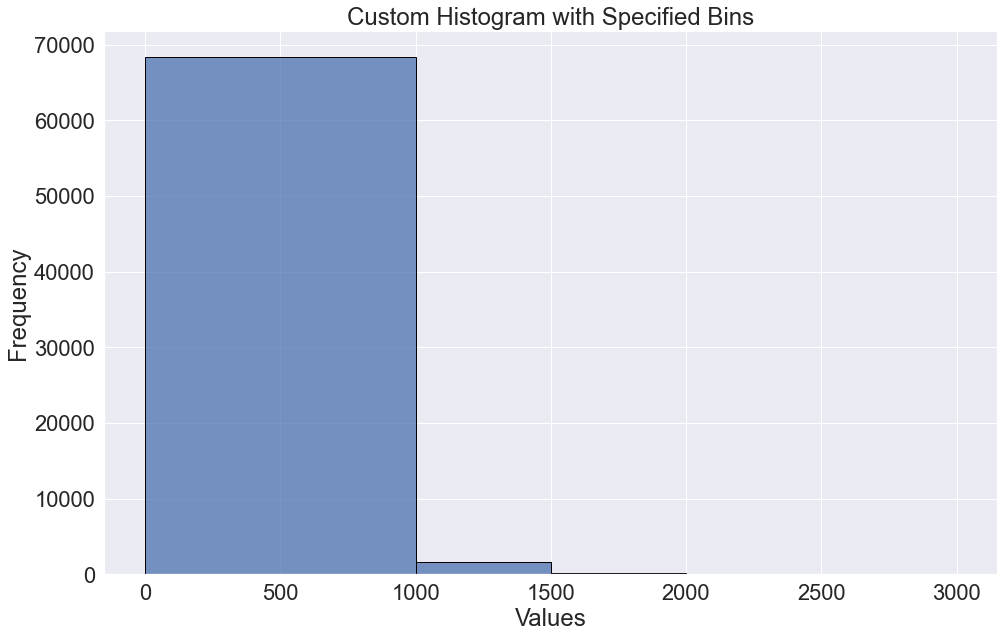

In [31]:
# We are defining custom bin edges to see turnover distribution 
bin_edges = [0, 1000, 1500, 2000, 2500, 3000]

# Plot histogram 
sns.histplot(data = df[df['dpt_num_department'] == 88]['turnover'], bins=bin_edges, kde=False, stat='count', edgecolor='black')


plt.title('Custom Histogram with Specified Bins')
plt.xlabel('Values')
plt.ylabel('Frequency')


plt.show()

Text(0.5, 1.0, 'Turnover by Date for Department 88')

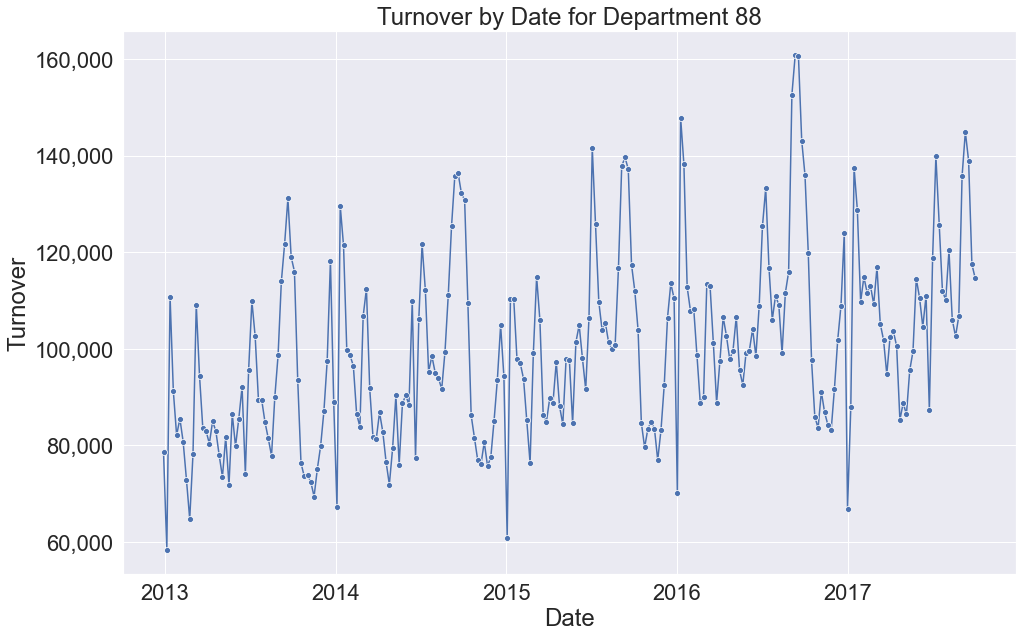

In [32]:
## Let's see department 88 over time again but wthout the outlier
sns.lineplot(x='day_id', y='turnover', data=df[(df['dpt_num_department'] == 88) & (df['turnover'] < 1000000)], marker='o', estimator=sum, errorbar=None)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.xlabel('Date')  
plt.ylabel('Turnover')
plt.title('Turnover by Date for Department 88')


In [33]:
### Let's remove the outlier in department 88

In [34]:
df = df[~((df['dpt_num_department'] == 88) & (df['turnover'] >= 1000000.00))]

### 3. Turnover by Department and Business Unit
__Insights__ 
1.  There is no indication that the number of stores per department or the number of stores per region per department affects turnover

#### 3.1. let's see if the number of stores by department affects the turnover 

In [35]:
df.groupby(['dpt_num_department'])['but_num_business_unit'].nunique()

dpt_num_department
73     316
88     322
117    315
127    317
Name: but_num_business_unit, dtype: int64

#### 3.2. Next, let's see if postcode or region affect the turnover

In [36]:
df.groupby(['dpt_num_department'])['but_postcode'].nunique()

dpt_num_department
73     304
88     308
117    301
127    304
Name: but_postcode, dtype: int64

In [37]:
df.groupby(['dpt_num_department'])['but_region_idr_region'].nunique()

dpt_num_department
73     29
88     29
117    29
127    29
Name: but_region_idr_region, dtype: int64

#### 3.3. How many units by postcode for a department?

In [38]:
upd = df.groupby(['dpt_num_department','but_region_idr_region'])['but_num_business_unit'].nunique().reset_index()

In [39]:
upd

,dpt_num_department,but_region_idr_region,but_num_business_unit
0,73,2,12
1,73,3,11
2,73,4,10
3,73,6,10
4,73,7,12
5,73,8,10
6,73,30,13
7,73,31,11
8,73,32,9
9,73,33,2


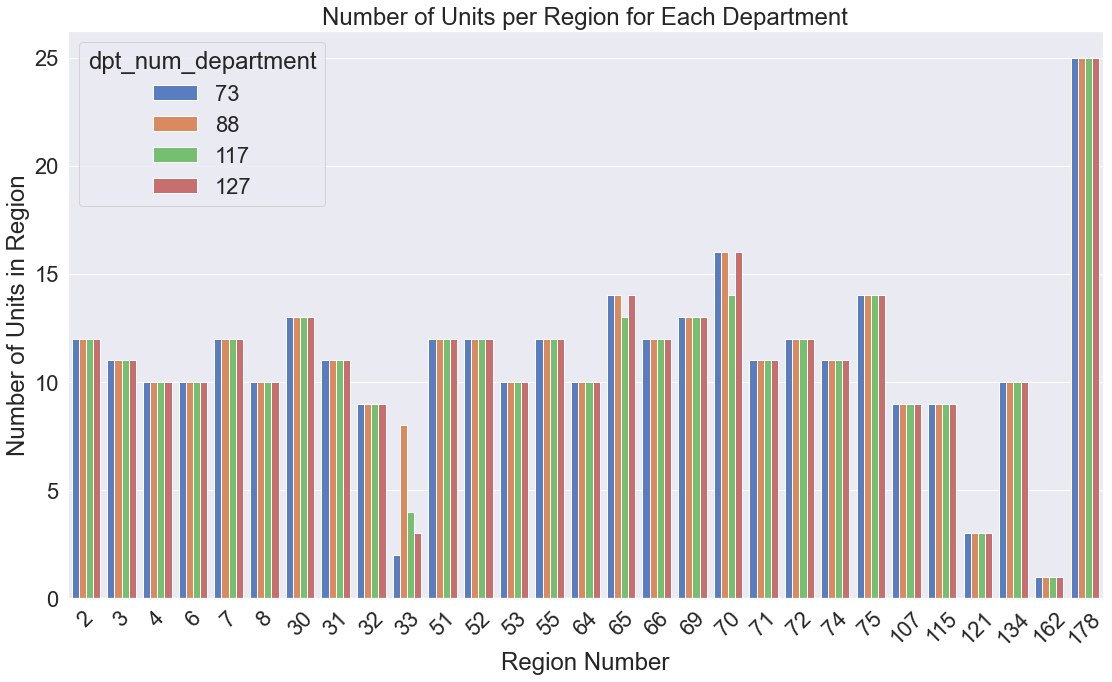

In [40]:
# Plotting barplots for the number of stores in a region for each department
sns.barplot(x='but_region_idr_region', y='but_num_business_unit', hue='dpt_num_department', data=upd, palette="muted")


plt.title('Number of Units per Region for Each Department')
plt.xlabel('Region Number')
plt.ylabel('Number of Units in Region')

plt.xticks(rotation=45)  

plt.tight_layout()
plt.show()

#### 3.4. Next, let's see if the zones make a difference in turnover for a department

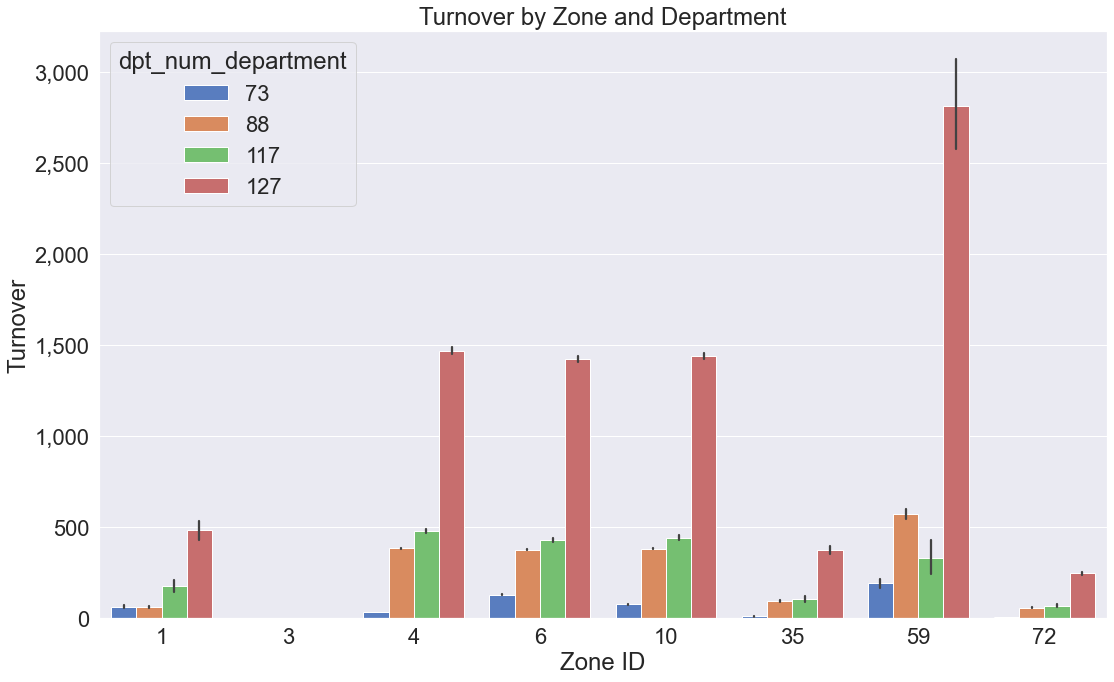

In [41]:
# Plotting barplots for the number of stores in a region for each department
sns.barplot(x='zod_idr_zone_dgr', y='turnover', hue='dpt_num_department', data=df, palette="muted")

plt.title('Turnover by Zone and Department')
plt.xlabel('Zone ID')
plt.ylabel('Turnover')

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.tight_layout()
plt.show()

In [42]:
## Creating a FacetGrid to plot the revenue over time for each department and zone is computationally expensive, so I've commented out 
## the cell below and I'm going to create different plots for the different departments

In [43]:
# Create a FacetGrid for each department
#g = sns.FacetGrid(df, col='dpt_num_department',  hue='zod_idr_zone_dgr', col_wrap=2, height=12, aspect=2)
#g.map_dataframe(sns.lineplot, x='day_id', y='turnover', marker='o')
#g.add_legend()

# Set titles
#g.set_titles('{col_name}')
#g.set_xlabels('Date')
#g.set_ylabels('Turnover')
#g.fig.suptitle('Turnover Over Time by Department')

#plt.tight_layout()
#plt.show()

Text(0.5, 1.0, 'Turnover by Date and Zone for Department 73')

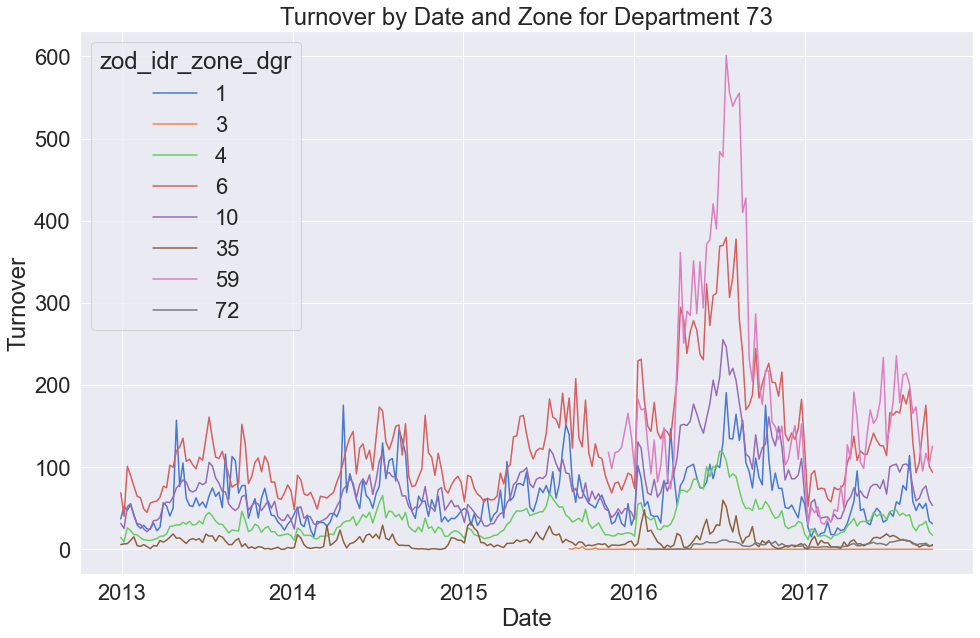

In [44]:
## Let's see the turnover over time for department 73 and its zones

sns.lineplot(x='day_id', y='turnover', data=df[df['dpt_num_department'] == 73], hue = 'zod_idr_zone_dgr', palette="muted", errorbar=None,)

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.xlabel('Date')  
plt.ylabel('Turnover')
plt.title('Turnover by Date and Zone for Department 73')


Text(0.5, 1.0, 'Turnover by Date and Zone for Department 88')

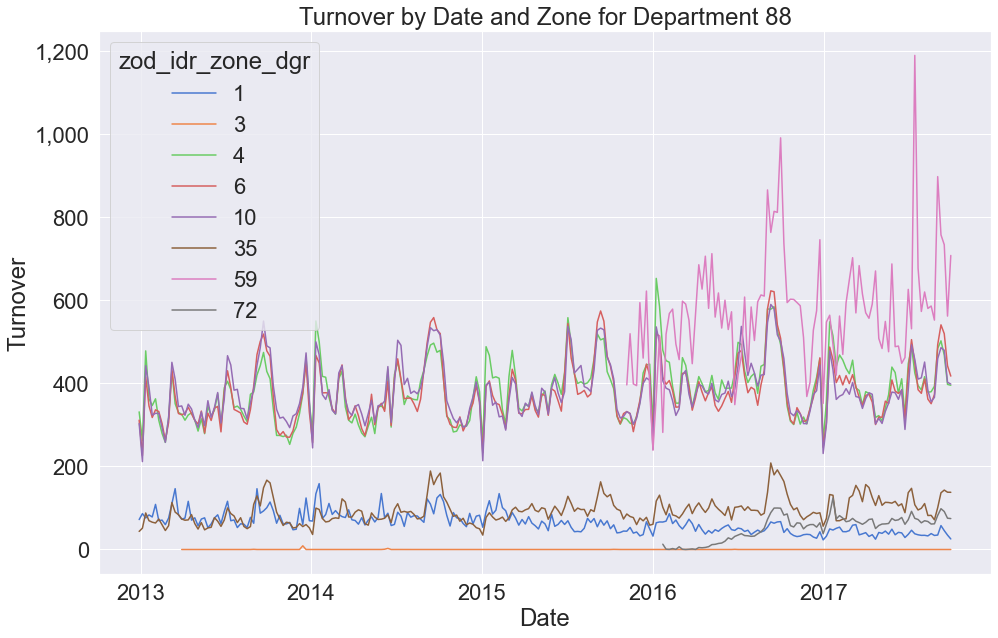

In [45]:
## Let's see the turnover over time for department 88 and its zones

sns.lineplot(x='day_id', y='turnover', data=df[df['dpt_num_department'] == 88], hue = 'zod_idr_zone_dgr', palette="muted", errorbar=None,)

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.xlabel('Date')  
plt.ylabel('Turnover')
plt.title('Turnover by Date and Zone for Department 88')


Text(0.5, 1.0, 'Turnover by Date and Zone for Department 117')

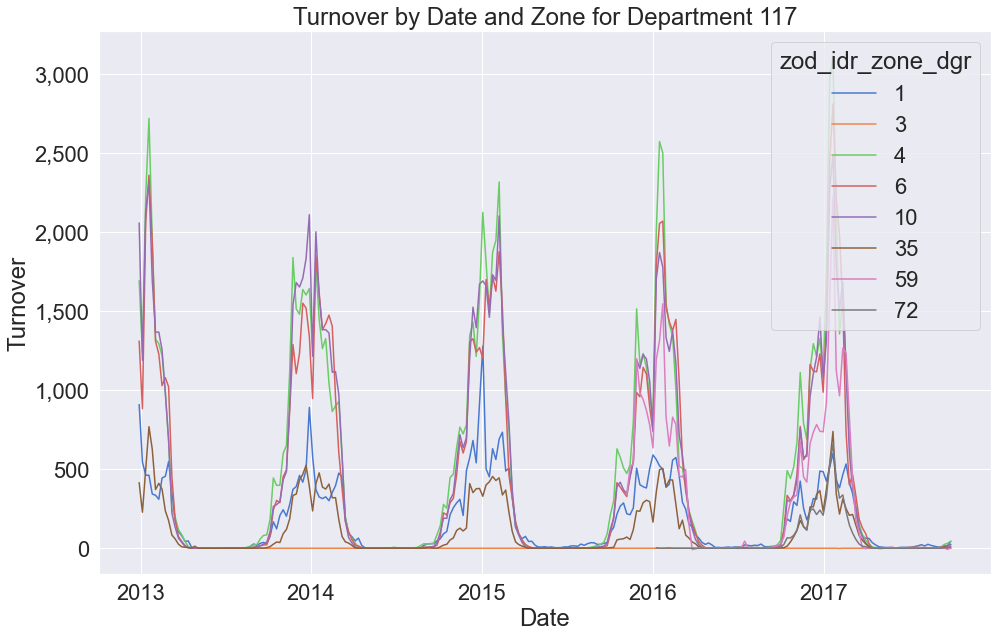

In [46]:
## Let's see the turnover over time for department 117 and its zones

sns.lineplot(x='day_id', y='turnover', data=df[df['dpt_num_department'] == 117], hue = 'zod_idr_zone_dgr', palette="muted", errorbar=None,)

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.xlabel('Date')  
plt.ylabel('Turnover')
plt.title('Turnover by Date and Zone for Department 117')


Text(0.5, 1.0, 'Turnover by Date and Zone for Department 127')

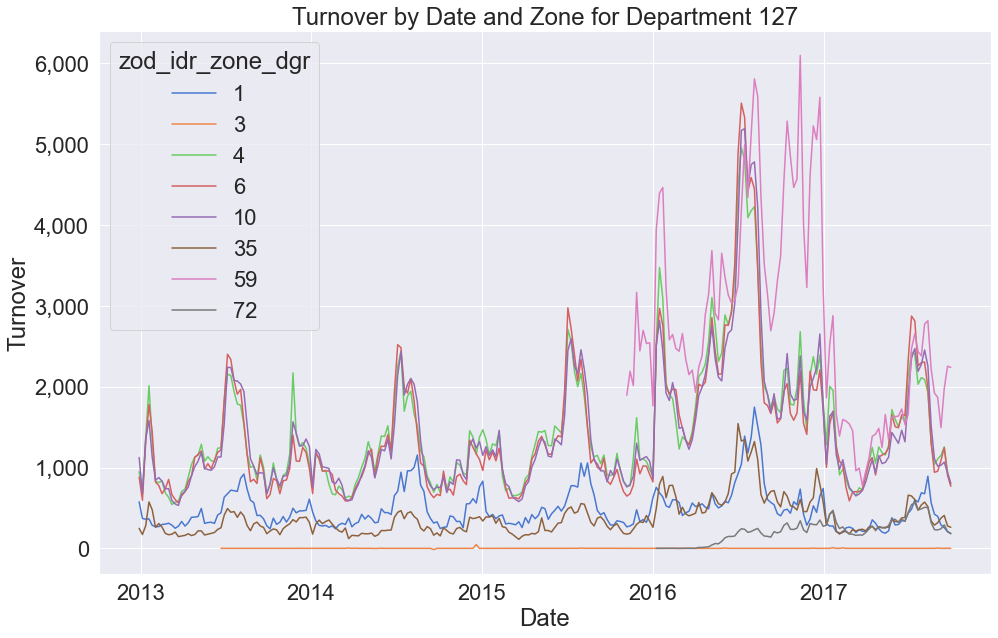

In [47]:
## Let's see the turnover over time for department 127 and its zones

sns.lineplot(x='day_id', y='turnover', data=df[df['dpt_num_department'] == 127], hue = 'zod_idr_zone_dgr', palette="muted", errorbar=None,)

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.xlabel('Date')  
plt.ylabel('Turnover')
plt.title('Turnover by Date and Zone for Department 127')


## Time Series Statistical Tests

### 4. Stationarity Check
__Why is it used?__ By stationarity, we mean constant averages, variances, and autocovariances over time. Because often time series models assume stationarity, if the data is non-stationary, it can lead to incorrect forecasts.
We are going to do 3 tests: the Augmented Dickey-Fuller test, the Phillips-Perron test, and the Kwiatkovski-Phillips_Schmidt-Shin test

In [48]:
time_series = df['turnover']

#### 4.1. Augmented Dickey-Fuller (ADF) test

In [49]:
## The ADF test checks if a time series can be represented by a model where it has no trend or consistent growth. 
## It does this by testing if the root of the equation is less than 1, 
## indicating that shocks to the time series die out over time rather than persisting.

result_adf = adfuller(time_series, autolag='AIC')
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])

print('Critical Values:')
for key, value in result_adf[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -21.490855052462095
p-value: 0.0
Critical Values:
	1%: -3.430373554313357
	5%: -2.8615504107108807
	10%: -2.5667755412443145


In [50]:
# The ADF statistic checks whether the time series is stationary. The more negative this number, the stronger the evidence 
# against the null hypothesis of non-stationarity. Our test shows a large negative number, which suggests there is no non-stationarity.

#### 4.2. Phillips-Perron (PP) test

In [51]:
## The PP test adjusts the ADF test to account for any serial correlation and changing variability in the data, 
## making it a more general and reliable test under certain conditions.

result_pp = adfuller(time_series, regression='n')
print('PP Statistic:', result_pp[0])
print('p-value:', result_pp[1])

print('Critical Values:')
for key, value in result_pp[4].items():
    print(f'\t{key}: {value}')

PP Statistic: -8.73389343204317
p-value: 6.9328569619746476e-15
Critical Values:
	1%: -2.5657480532403465
	5%: -1.9410009675218372
	10%: -1.6168190433628162


In [52]:
## The PP statistic also checks for is non-stationarity. The more negative it is, the stronger the evidence against the null hypothesis. 
## Our test is a negative number, , which suggests there is no non-stationarity.

#### 4.3. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [53]:
## The KPSS test checks if the variance of a time series around a deterministic trend is stable over time. 
## If the variance is stable, the time series is considered trend-stationary.
result_kpss = kpss(time_series, regression='c', nlags='auto')
print('KPSS Statistic:', result_kpss[0])
print('p-value:', result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
    print(f'\t{key}: {value}')

KPSS Statistic: 7.601686861814922
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [54]:
## The KPSS statistic tests whether a time series is stationary around a mean. Higher values of the KPSS statistic indicate 
## stronger evidence against the null hypothesis. Our test shows a positive number, which suggest the time series is not
## stationary around a mean.

### 5. Seasonality Decomposition
___Why is it used?__ Decomposing the time series helps to break down the time series into three components: trend (long-term direction), seasonal (periodic fluctuations), and residual (random fluctuations).

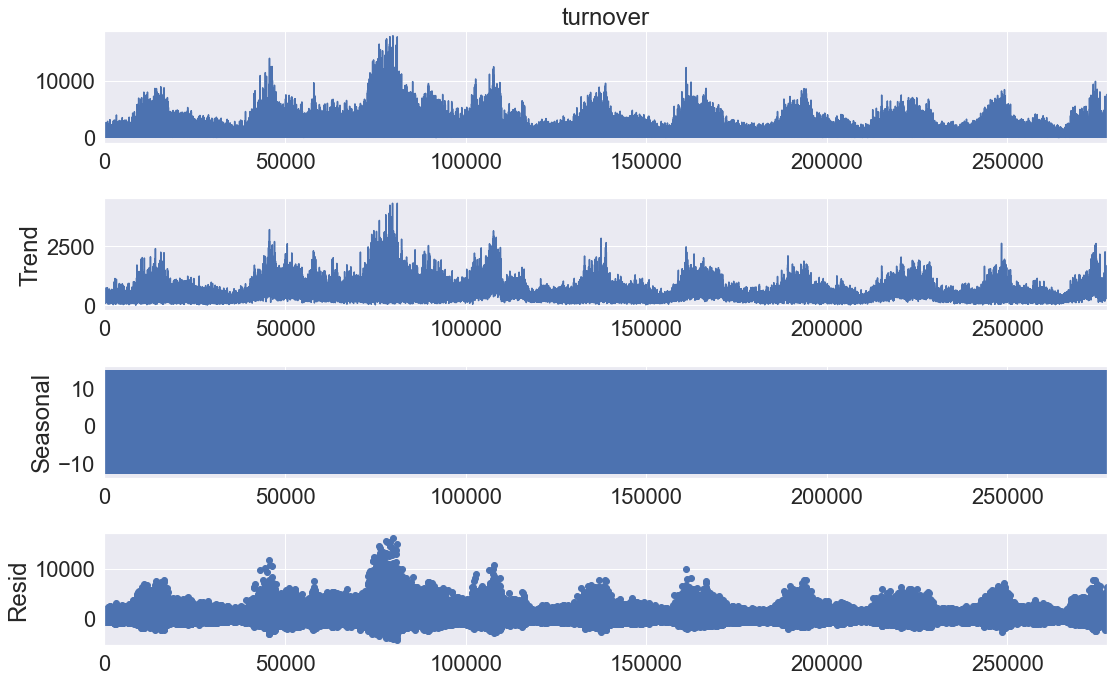

In [55]:
result = seasonal_decompose(df['turnover'], model='additive', period=12) ## this is additive and not multiplicative because there are 0s and negative values in turnover
fig = result.plot()
plt.show()

### 6. Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
___Why is it used?___ ACF measures the correlation between a time series and its lagged values. PACF measures the correlation between a time series and its lagged values that are not explained by intervening values.

<Figure size 864x432 with 0 Axes>

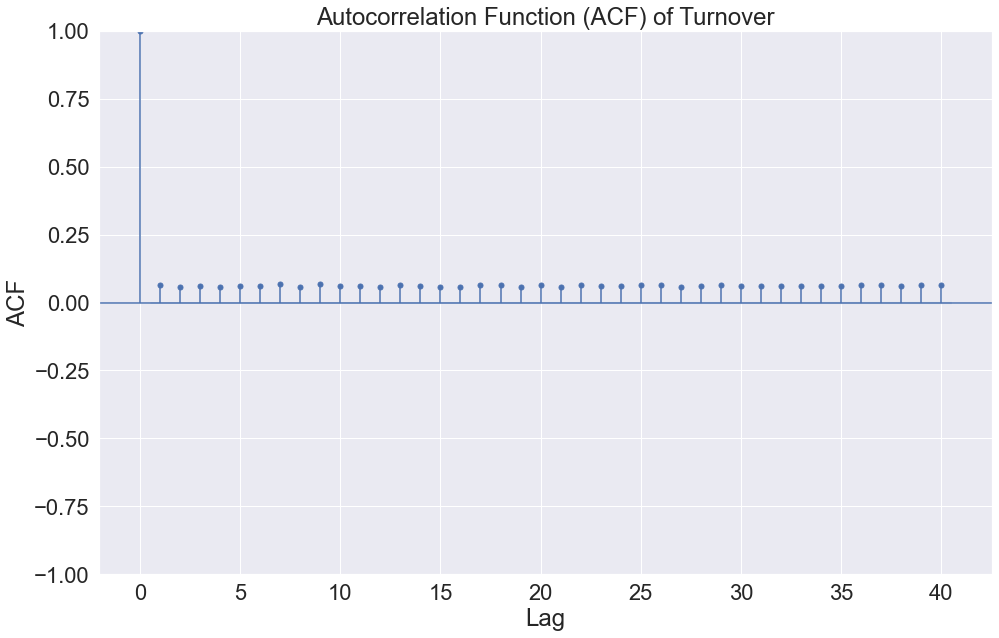

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plt.figure(figsize=(12, 6))
plot_acf(df['turnover'], lags=40, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of Turnover')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x432 with 0 Axes>

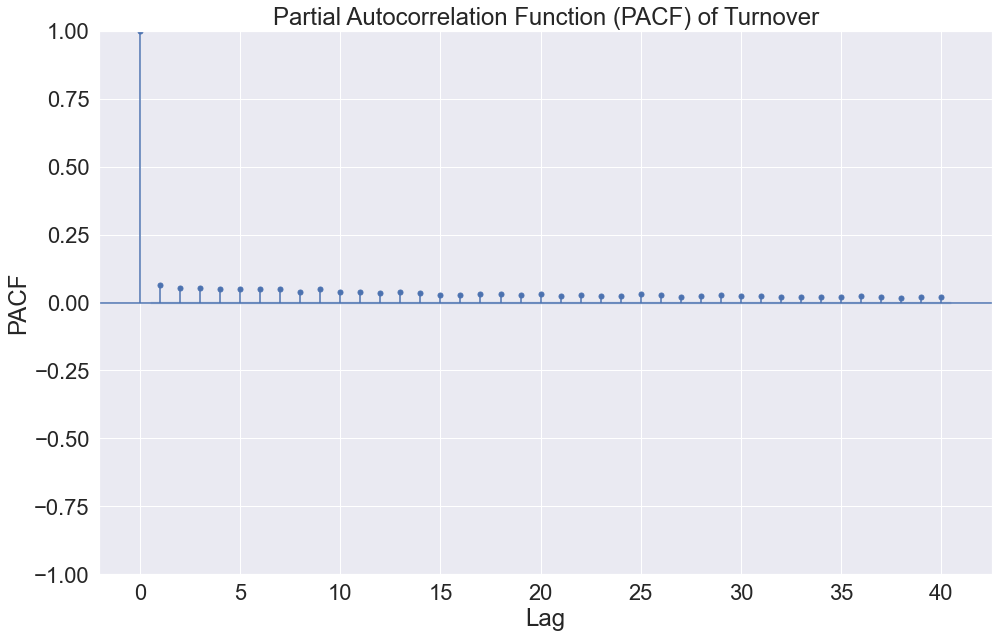

In [57]:
# PACF plot
plt.figure(figsize=(12, 6))
plot_pacf(df['turnover'], lags=40, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) of Turnover')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

In [58]:
## We can see from the ACF and PACF tests that there is a lag of 2, which means that turnover is influenced by the turnover of 
## up to two weeks before


### 7. Lagging Feature Engineering

#### 7.1. Let's see how turnover changes by week for each business unit and department

In [59]:
df = df.sort_values(by=['day_id'])

In [60]:
# We need to create new columns for turnover 1 week before, 2 weeks before, etc., up to 8 weeks before
weeks_before = 8
for i in range(1, weeks_before + 1):
    df[f'turnover_{i}_week_before'] = df.groupby(['but_num_business_unit', 'dpt_num_department'])['turnover'].shift(i)

In [61]:
df = df.fillna(0)

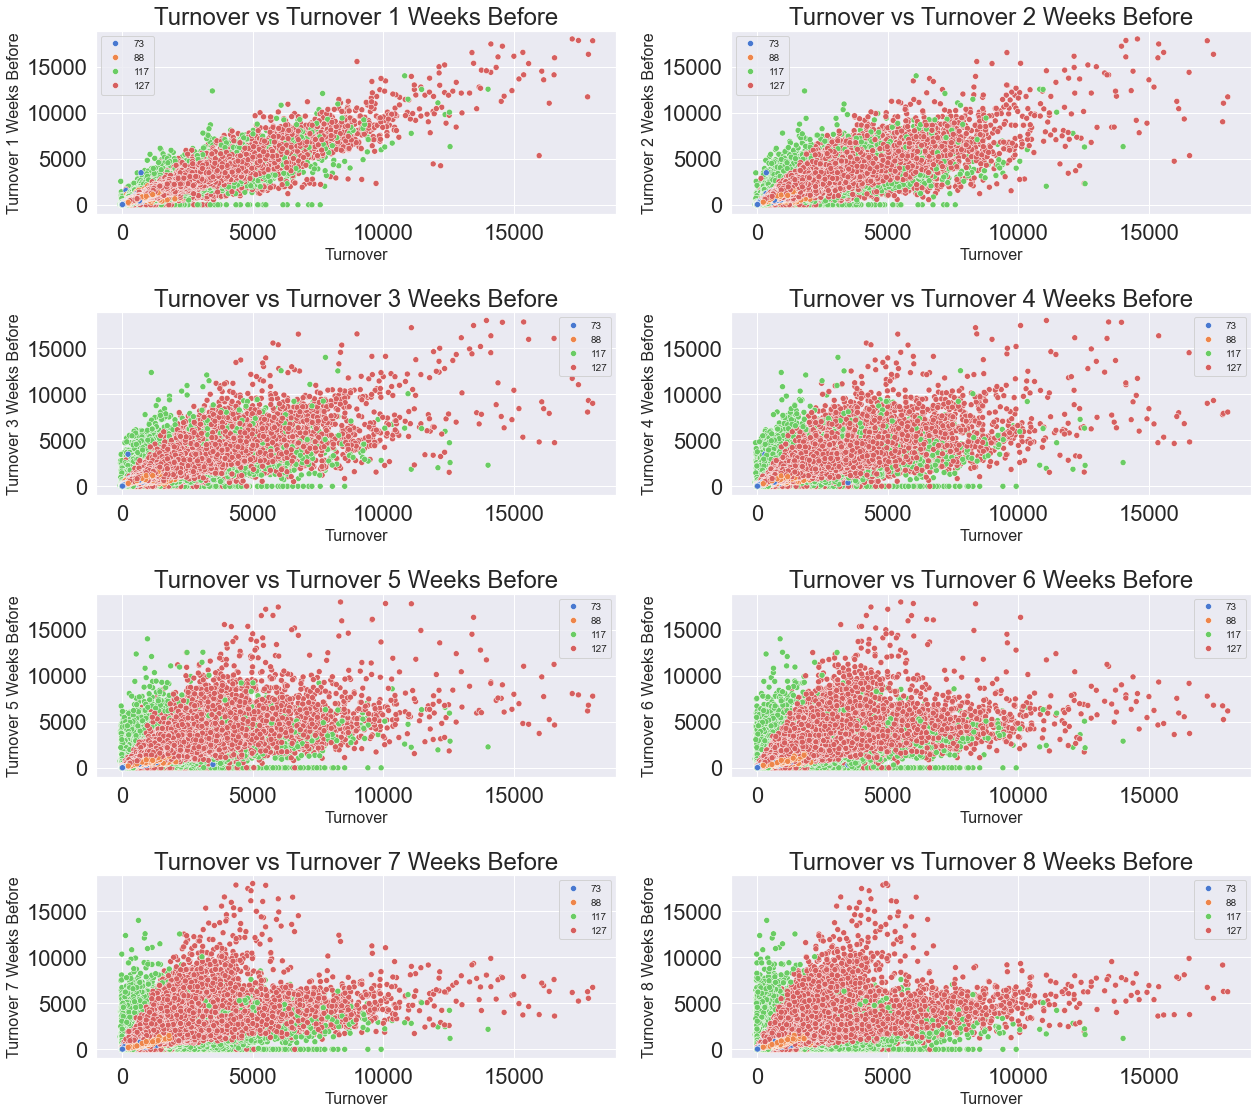

In [62]:
# This creates a grid of scatter plots with 4 rows and 2 columns
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 16))

for i in range(1, weeks_before + 1):
    row = (i - 1) // 2
    col = (i - 1) % 2
    ax = axes[row, col]
    sns.scatterplot(data=df, x='turnover', y=f'turnover_{i}_week_before', hue='dpt_num_department', palette='muted', ax=ax)
    ax.set_xlabel('Turnover', fontsize=16)
    ax.set_ylabel(f'Turnover {i} Weeks Before', fontsize=16) 
    ax.set_title(f'Turnover vs Turnover {i} Weeks Before')
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

In [63]:
## From the scatterplots above, we can see that turnover from weeks 1 and 2 before show correlation with turnover

In [64]:
df = df.sort_values(by=['day_id', 'but_num_business_unit', 'dpt_num_department'])

# Calculate the rolling mean for each business unit and department
df['rolling_mean_4_weeks'] = df.groupby(['but_num_business_unit', 'dpt_num_department'])['turnover'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())
df['rolling_mean_2_weeks'] = df.groupby(['but_num_business_unit', 'dpt_num_department'])['turnover'].transform(lambda x: x.rolling(window=2, min_periods=1).mean())

#### 7.1. Let's see skewness and kurtosis

In [65]:
print("Skewness:", df['turnover'].skew())

Skewness: 3.96874054136375


In [66]:
## Skewness measures the asymmetry of a distribution around its mean. It indicates whether the data points are skewed to the left 
## or to the right. A skewness of 0 indicates a perfectly symmetrical distribution. Our value is 3.9, which means our data is highly skewed 
## to the right. This means there are many more low values and a few very high values.

In [67]:
print("Kurtosis:", df['turnover'].kurtosis())

Kurtosis: 26.734054104820782


In [68]:
## Kurtosis indicates how heavy or light the tails of the distribution are compared to a normal distribution. Our value is 26.7, which is a very high
## kurtostis, which means that suggesting there are very heavy tails and a sharp peak. 

In [69]:
df['average_quarterly_turnover'] = df.groupby(['year', 'quarter', 'but_num_business_unit', 'dpt_num_department'])['turnover'].transform('mean')

In [70]:
df.head()

,day_id,but_num_business_unit,dpt_num_department,turnover,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr,year,month,week,quarter,turnover_1_week_before,turnover_2_week_before,turnover_3_week_before,turnover_4_week_before,turnover_5_week_before,turnover_6_week_before,turnover_7_week_before,turnover_8_week_before,rolling_mean_4_weeks,rolling_mean_2_weeks,average_quarterly_turnover
277268,2012-12-29,1,73,15.552508,59320,50.628060,2.957377,65,4,2012,12,52,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.552508,15.552508,15.552508
276941,2012-12-29,1,88,306.927510,59320,50.628060,2.957377,65,4,2012,12,52,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,306.927510,306.927510,306.927510
277208,2012-12-29,1,117,972.944128,59320,50.628060,2.957377,65,4,2012,12,52,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,972.944128,972.944128,972.944128
277321,2012-12-29,1,127,665.646079,59320,50.628060,2.957377,65,4,2012,12,52,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,665.646079,665.646079,665.646079
277085,2012-12-29,2,73,38.474503,59960,50.741153,3.134613,65,4,2012,12,52,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.474503,38.474503,38.474503


## Forecasts

In [71]:
df['turnover_by_store_dpt'] = df.groupby(['but_num_business_unit', 'dpt_num_department'])['turnover'].transform('sum')

In [72]:
## I'm going to use this dataset later in inference and I need the day_id to be date and not index, so I'm saving copying it
df_for_inference = df.copy()

In [73]:
## I also need another df for the ARIMA, SARIMA, and ETS models, so the day_id column isn't an index
df_for_models = df.copy()

In [74]:
## We are going to test the XGBoost forecast on the last 12 months in our dataset, and use the remaining data to train the model

In [75]:
## We need to turn the day_id column into an index so the time series can understand it.
df.set_index('day_id', inplace=True)
df = df.sort_index()

# We get the latest date in our dataset
max_day_id = df.index.max()

# Based on that, we calculate the date that's 12 months before the latest date, and that's our boundary to cut off training/testing data
boundary = max_day_id - pd.DateOffset(months=12)

In [76]:
# Split the dataset into training and test sets
train_df = df[df.index < boundary]
test_df = df[df.index >= boundary]

In [77]:
train_df.head()

,but_num_business_unit,dpt_num_department,turnover,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr,year,month,week,quarter,turnover_1_week_before,turnover_2_week_before,turnover_3_week_before,turnover_4_week_before,turnover_5_week_before,turnover_6_week_before,turnover_7_week_before,turnover_8_week_before,rolling_mean_4_weeks,rolling_mean_2_weeks,average_quarterly_turnover,turnover_by_store_dpt
day_id,,,,,,,,,,,,,,,,,,,,,,,,
2012-12-29,1,73,15.552508,59320,50.628060,2.957377,65,4,2012,12,52,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.552508,15.552508,15.552508,10727.897559
2012-12-29,1,88,306.927510,59320,50.628060,2.957377,65,4,2012,12,52,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,306.927510,306.927510,306.927510,84318.204258
2012-12-29,1,117,972.944128,59320,50.628060,2.957377,65,4,2012,12,52,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,972.944128,972.944128,972.944128,75837.174243
2012-12-29,1,127,665.646079,59320,50.628060,2.957377,65,4,2012,12,52,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,665.646079,665.646079,665.646079,226964.061391
2012-12-29,2,73,38.474503,59960,50.741153,3.134613,65,4,2012,12,52,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.474503,38.474503,38.474503,14738.507274


In [78]:
test_df.head()

,but_num_business_unit,dpt_num_department,turnover,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr,year,month,week,quarter,turnover_1_week_before,turnover_2_week_before,turnover_3_week_before,turnover_4_week_before,turnover_5_week_before,turnover_6_week_before,turnover_7_week_before,turnover_8_week_before,rolling_mean_4_weeks,rolling_mean_2_weeks,average_quarterly_turnover,turnover_by_store_dpt
day_id,,,,,,,,,,,,,,,,,,,,,,,,
2016-10-01,1,73,94.146381,59320,50.628060,2.957377,65,4,2016,10,39,4,75.821179,151.520645,102.955125,146.584773,100.133810,104.376110,129.331150,161.286882,106.110832,84.983780,48.134259,10727.897559
2016-10-01,1,88,293.202360,59320,50.628060,2.957377,65,4,2016,10,39,4,257.992539,340.088016,363.504128,353.173510,229.780205,271.809747,182.258912,283.542499,313.696761,275.597450,258.601240,84318.204258
2016-10-01,1,117,1.906406,59320,50.628060,2.957377,65,4,2016,10,39,4,0.965120,1.834268,0.095018,1.206320,1.904181,1.427500,1.428136,0.888533,1.200203,1.435763,409.570909,75837.174243
2016-10-01,1,127,706.067029,59320,50.628060,2.957377,65,4,2016,10,39,4,477.730214,515.751234,577.631086,815.490827,852.334795,773.915292,1358.657454,1665.679346,569.294890,591.898621,1156.886832,226964.061391
2016-10-01,2,73,91.965076,59960,50.741153,3.134613,65,4,2016,10,39,4,50.179561,75.290789,78.811557,61.154343,51.936352,52.980220,100.669273,96.139563,74.061746,71.072318,71.837832,14738.507274


In [79]:
train_df.columns

Index(['but_num_business_unit', 'dpt_num_department', 'turnover',
       'but_postcode', 'but_latitude', 'but_longitude',
       'but_region_idr_region', 'zod_idr_zone_dgr', 'year', 'month', 'week',
       'quarter', 'turnover_1_week_before', 'turnover_2_week_before',
       'turnover_3_week_before', 'turnover_4_week_before',
       'turnover_5_week_before', 'turnover_6_week_before',
       'turnover_7_week_before', 'turnover_8_week_before',
       'rolling_mean_4_weeks', 'rolling_mean_2_weeks',
       'average_quarterly_turnover', 'turnover_by_store_dpt'],
      dtype='object')

In [80]:
## Let's remove the turnover column because we are going to use turnover_by_store_dpt
train_df = train_df.drop(columns=['turnover'])
test_df = test_df.drop(columns=['turnover'])

## 8. XGBoost for Time Series

In [81]:
X_train = train_df.loc[:, train_df.columns != 'turnover_by_store_dpt']
y_train = train_df['turnover_by_store_dpt']  

In [82]:
X_test = test_df.loc[:, test_df.columns != 'turnover_by_store_dpt']
y_test = test_df['turnover_by_store_dpt'] 

In [83]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()

In [84]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
hyperparameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

In [85]:
# Perform randomized search cross-validation
search = RandomizedSearchCV(xgb_model, hyperparameters, scoring='r2', cv=5, n_iter=8)
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=8,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.7, 0.8, 0.9]},
                   scoring='r2')

In [86]:
# Get the best model and its hyperparameters
best_model = search.best_estimator_
best_hyperparameters = search.best_params_

In [87]:
# Evaluate the best model on the test set
y_pred_test = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred_test)
print(f"Best Model R2: {r2}")

Best Model R2: 0.8419181777461472


In [88]:
# Retrieve the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Best Hyperparameters:
subsample: 0.8
n_estimators: 300
max_depth: 7
learning_rate: 0.1
colsample_bytree: 0.8


Text(0.5, 1.0, 'Observed vs Predicted Daily Users Projection')

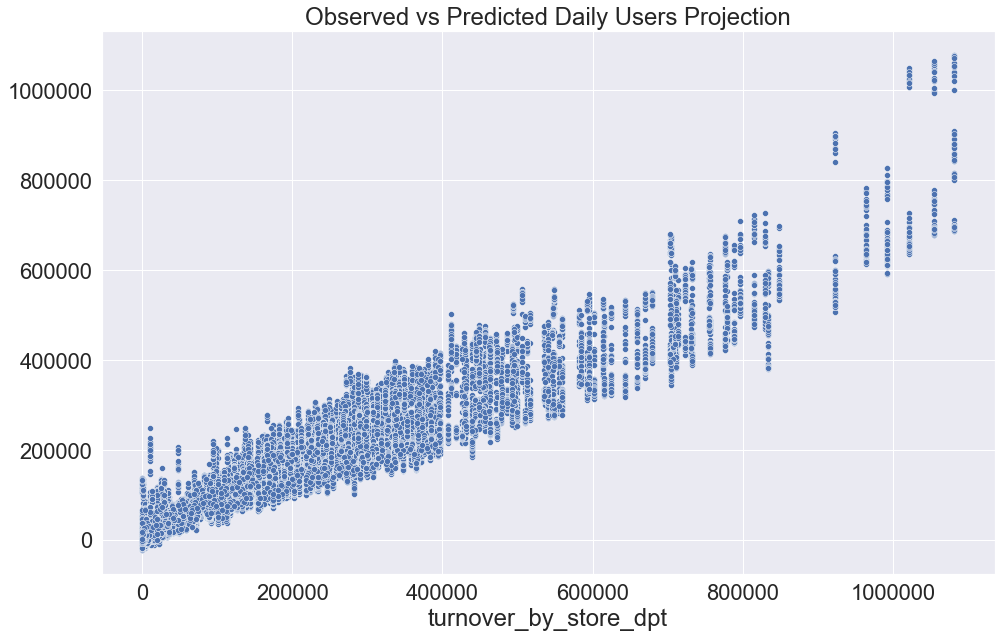

In [89]:
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
sns.scatterplot(x=y_test, y=y_pred_test).set_title('Observed vs Predicted Daily Users Projection')

In [90]:
importance = best_model.feature_importances_
feature_names = X_train.columns

In [91]:
indices = np.argsort(importance)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importance = importance[indices]

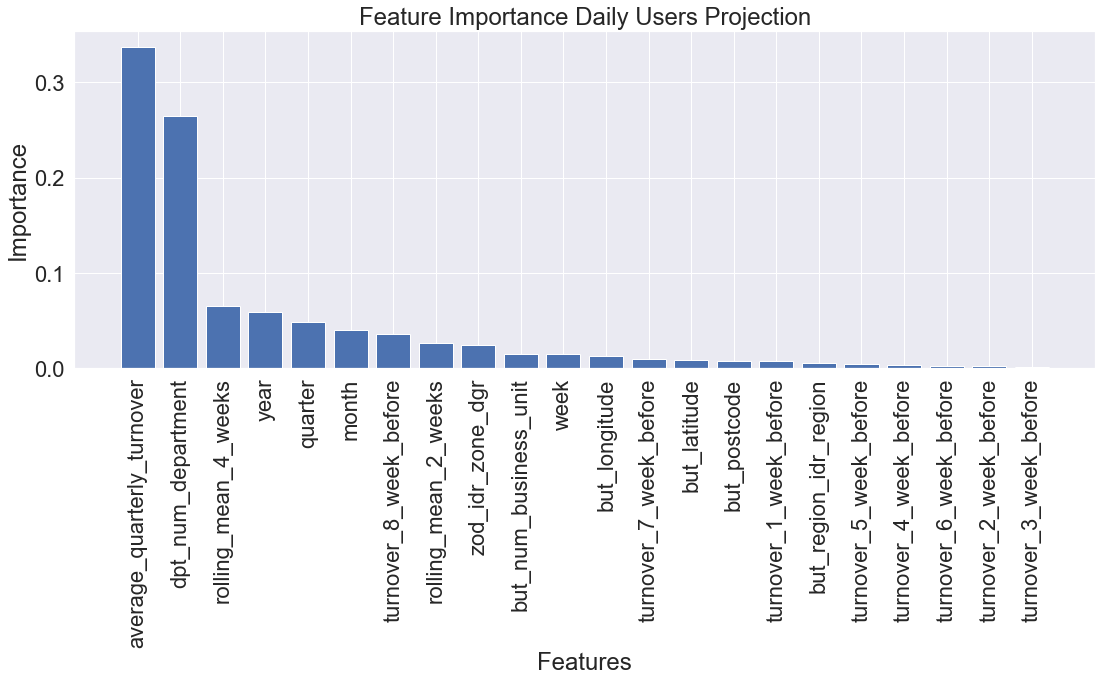

In [92]:
plt.bar(range(len(sorted_importance)), sorted_importance, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Daily Users Projection')
plt.tight_layout()
plt.show()

In [93]:
### Let's make the inference on the test.csv file

In [94]:
val_df['day_id'] = pd.to_datetime(val_df['day_id'])

In [95]:
## The function in the cell below is developed after first creating and testing the process in cells 93-199. The code iteratively
## looks for the turnover that we have for 1 week before our first inference, and iteratively looks for lagged features and projections

In [96]:

def forecast_turnover(val_df, df_for_inference, best_model, X_train_columns):
    # Ensure 'day_id' is in datetime format
    val_df['day_id'] = pd.to_datetime(val_df['day_id'])
    df_for_inference['day_id'] = pd.to_datetime(df_for_inference['day_id'])
    
    # Initialize the 'turnover' column in val_df if it doesn't exist
    if 'turnover' not in val_df.columns:
        val_df['turnover'] = np.nan

    # Find the earliest date in val_df
    unique_val_dates = sorted(val_df['day_id'].unique())

    # Loop through each unique date
    for i in range(len(unique_val_dates)):
        current_val_date = unique_val_dates[i]
        train_date_offset = pd.DateOffset(weeks=i+1)
        earliest_train_date = current_val_date - train_date_offset

        step_forecast = df_for_inference[df_for_inference['day_id'] == earliest_train_date]

        # Drop turnover and prior turnover columns dynamically
        columns_to_drop = ['turnover'] + [f'turnover_{j+1}_week_before' for j in range(i)]
        step_forecast = step_forecast.drop(columns=[col for col in columns_to_drop if col in step_forecast.columns])

        val_df_merged = pd.merge(
            val_df[val_df['day_id'] == current_val_date],
            step_forecast,
            on=['but_num_business_unit', 'dpt_num_department'],
            how='inner',
            suffixes=('', '_drop')
        ).drop(columns=['day_id_drop'], errors='ignore')

        for j in range(i):
            previous_val_date = unique_val_dates[i-j-1]
            if 'turnover' in val_df.columns and previous_val_date in val_df['day_id'].values:
                val_df_merged[f'turnover_{j+1}_week_before'] = val_df.loc[val_df['day_id'] == previous_val_date, 'turnover'].values

        # Ensure all necessary columns are present and fill missing values
        for col in X_train_columns:
            if col not in val_df_merged.columns:
                val_df_merged[col] = np.nan

        # Ensure correct data types
        val_df_merged = val_df_merged[X_train_columns].astype(float)

        y_pred_val = best_model.predict(val_df_merged)
        val_df.loc[val_df['day_id'] == current_val_date, 'turnover'] = y_pred_val

    return val_df

# Example usage
val_df = forecast_turnover(val_df, df_for_inference, best_model, X_train.columns)
val_df.to_csv('predictions.csv', index=False)


In [97]:
## Because we don't have turnover information in our inference dataset, we need to calculate the lagging features using
## turnover from our training dataset for the earliest week in the inference dataset.
## For example, our earlierst date in our inference dataset is 2017-10-07. To calculate the turnover_1_week_before and similar columns,
## we are going to take the turnovers for 2017-09-30 etc.

In [98]:
# # Find the earliest date in val_df
# earliest_val_date = val_df['day_id'].min()

# # To create the first iteration of the prediction, we need to calculate the lagging features, so we need to take up to 8 weeks of data from
# # the train_df before our earliest inference date
# earliest_train_date = earliest_val_date - pd.DateOffset(weeks=1)

In [99]:
# first_step_forecast = df_for_inference[df_for_inference['day_id'] == earliest_train_date]

In [100]:
# first_step_forecast.columns

In [101]:
# columns_to_keep = ['but_num_business_unit', 'dpt_num_department', 'quarter', 'turnover_1_week_before', 'turnover_2_week_before',
#        'turnover_3_week_before', 'turnover_4_week_before',
#        'turnover_5_week_before', 'turnover_6_week_before',
#        'turnover_7_week_before', 'turnover_8_week_before',
#        'rolling_mean_4_weeks', 'rolling_mean_2_weeks',
#        'average_quarterly_turnover', 'turnover_by_store_dpt']

In [102]:
# first_step_forecast = first_step_forecast.drop(columns=['turnover'])

In [103]:
# val_df_merged = pd.merge(val_df[val_df['day_id'] == earliest_val_date], first_step_forecast, on=['but_num_business_unit','dpt_num_department'], how='inner', suffixes=('', '_drop')).drop(columns=['day_id_drop', 'turnover_by_store_dpt'])

In [104]:
# val_df_merged.head()

In [108]:
#val_df_merged.columns

In [109]:
# val_df_merged.set_index('day_id', inplace=True)

In [110]:
# val_df_merged.head()

In [111]:
# val_df_merged.columns

In [112]:
# val_df[val_df['day_id']==earliest_val_date].head(20)

In [113]:
# val_df = val_df.sort_values(by='day_id')

In [114]:
# unique_val_dates = val_df.day_id.unique()

In [115]:
# # Find the second earliest date in val_df
# second_earliest_val_date = unique_val_dates[1]

# # To create the first iteration of the prediction, we need to calculate the lagging features, so we need to take up to 8 weeks of data from
# # the train_df before our earliest inference date
# second_earliest_train_date = second_earliest_val_date - pd.DateOffset(weeks=2)

In [116]:
# second_earliest_train_date

In [117]:
# second_step_forecast = df_for_inference[df_for_inference['day_id'] == second_earliest_train_date]

In [118]:
# second_step_forecast.head()

In [119]:
# second_step_forecast.columns

In [120]:
# second_step_forecast = second_step_forecast.drop(columns=['turnover', 'turnover_1_week_before'])

In [121]:
# val_df_merged = pd.merge(val_df[val_df['day_id'] == second_earliest_val_date], second_step_forecast, on=['but_num_business_unit','dpt_num_department'], how='inner', suffixes=('', '_drop')).drop(columns=['day_id_drop'])

In [122]:
# val_df_merged.head()

In [123]:
# val_df_merged.loc[val_df_merged['day_id'] == second_earliest_val_date, 'turnover_1_week_before'] = val_df.loc[val_df['day_id'] == earliest_val_date, 'turnover'].values

In [124]:
# val_df_merged.head()

In [125]:
# val_df_merged = val_df_merged.drop(columns=['turnover'])

In [126]:
# val_df_merged = val_df_merged[X_train.columns]

In [127]:
# y_pred_val_2 = best_model.predict(val_df_merged)

In [128]:
# y_pred_val_2

In [129]:
# val_df.loc[val_df['day_id'] == second_earliest_val_date, 'turnover'] = y_pred_val_2

In [130]:
# val_df.loc[val_df['day_id'] == second_earliest_val_date]

In [131]:
# second_earliest_val_date

In [132]:
# # Get the third earliest date
# third_earliest_val_date = unique_val_dates[2]

# # To create the first iteration of the prediction, we need to calculate the lagging features, so we need to take up to 8 weeks of data from
# # the train_df before our earliest inference date
# third_earliest_train_date = third_earliest_val_date - pd.DateOffset(weeks=3)


In [133]:
# third_step_forecast = df_for_inference[df_for_inference['day_id'] == third_earliest_train_date]

In [134]:
# third_step_forecast = third_step_forecast.drop(columns=['turnover', 'turnover_1_week_before', 'turnover_2_week_before'])

In [135]:
# third_step_forecast.columns

In [136]:
# val_df_merged = pd.merge(val_df[val_df['day_id'] == third_earliest_val_date], third_step_forecast, on=['but_num_business_unit','dpt_num_department'], how='inner', suffixes=('', '_drop')).drop(columns=['day_id_drop'])

In [137]:
#val_df_merged = val_df_merged.drop(columns=['turnover'])
# val_df_merged = val_df_merged.drop(columns=['turnover_by_store_dpt'])

In [138]:
# val_df_merged.loc[val_df_merged['day_id'] == third_earliest_val_date, 'turnover_1_week_before'] = val_df.loc[val_df['day_id'] == second_earliest_val_date, 'turnover'].values

In [139]:
# val_df_merged.loc[val_df_merged['day_id'] == third_earliest_val_date, 'turnover_2_week_before'] = val_df.loc[val_df['day_id'] == earliest_val_date, 'turnover'].values

In [140]:
# val_df_merged = val_df_merged[X_train.columns]

In [141]:
# y_pred_val_3 = best_model.predict(val_df_merged)

In [142]:
# val_df.loc[val_df['day_id'] == third_earliest_val_date, 'turnover'] = y_pred_val_3

In [143]:
# # Get the third earliest date
# fourth_earliest_val_date = unique_val_dates[3]

# # To create the first iteration of the prediction, we need to calculate the lagging features, so we need to take up to 8 weeks of data from
# # the train_df before our earliest inference date
# fourth_earliest_train_date = fourth_earliest_val_date - pd.DateOffset(weeks=4)


In [144]:
# fourth_step_forecast = df_for_inference[df_for_inference['day_id'] == fourth_earliest_train_date]

In [145]:
# fourth_step_forecast = fourth_step_forecast.drop(columns=['turnover', 'turnover_1_week_before', 'turnover_2_week_before', 'turnover_3_week_before'])

In [146]:
# val_df_merged = pd.merge(val_df[val_df['day_id'] == fourth_earliest_val_date], fourth_step_forecast, on=['but_num_business_unit','dpt_num_department'], how='inner', suffixes=('', '_drop')).drop(columns=['day_id_drop', 'turnover', 'turnover_by_store_dpt'])

In [147]:
# val_df_merged.loc[val_df_merged['day_id'] == fourth_earliest_val_date, 'turnover_1_week_before'] = val_df.loc[val_df['day_id'] == third_earliest_val_date, 'turnover'].values

In [148]:
# val_df_merged.loc[val_df_merged['day_id'] == fourth_earliest_val_date, 'turnover_2_week_before'] = val_df.loc[val_df['day_id'] == second_earliest_val_date, 'turnover'].values

In [149]:
# val_df_merged.loc[val_df_merged['day_id'] == fourth_earliest_val_date, 'turnover_3_week_before'] = val_df.loc[val_df['day_id'] == earliest_val_date, 'turnover'].values

In [150]:
# val_df_merged.columns

In [151]:
# val_df_merged = val_df_merged[X_train.columns]

In [152]:
# y_pred_val_4 = best_model.predict(val_df_merged)

In [153]:
# val_df.loc[val_df['day_id'] == fourth_earliest_val_date, 'turnover'] = y_pred_val_4

In [154]:
# # Get the third earliest date
# fifth_earliest_val_date = unique_val_dates[4]

# # To create the first iteration of the prediction, we need to calculate the lagging features, so we need to take up to 8 weeks of data from
# # the train_df before our earliest inference date
# fifth_earliest_train_date = fifth_earliest_val_date - pd.DateOffset(weeks=5)


In [155]:
# fifth_step_forecast = df_for_inference[df_for_inference['day_id'] == fifth_earliest_train_date]

In [156]:
# fifth_step_forecast = fifth_step_forecast.drop(columns=['turnover', 'turnover_1_week_before', 'turnover_2_week_before', 'turnover_3_week_before', 'turnover_4_week_before'])

In [157]:
# val_df_merged = pd.merge(val_df[val_df['day_id'] == fifth_earliest_val_date], fifth_step_forecast, on=['but_num_business_unit','dpt_num_department'], how='inner', suffixes=('', '_drop')).drop(columns=['day_id_drop', 'turnover', 'turnover_by_store_dpt'])

In [158]:
# val_df_merged.loc[val_df_merged['day_id'] == fifth_earliest_val_date, 'turnover_1_week_before'] = val_df.loc[val_df['day_id'] == fourth_earliest_val_date, 'turnover'].values

In [159]:
# val_df_merged.loc[val_df_merged['day_id'] == fifth_earliest_val_date, 'turnover_2_week_before'] = val_df.loc[val_df['day_id'] == third_earliest_val_date, 'turnover'].values

In [160]:
# val_df_merged.loc[val_df_merged['day_id'] == fifth_earliest_val_date, 'turnover_3_week_before'] = val_df.loc[val_df['day_id'] == second_earliest_val_date, 'turnover'].values

In [161]:
# val_df_merged.loc[val_df_merged['day_id'] == fifth_earliest_val_date, 'turnover_4_week_before'] = val_df.loc[val_df['day_id'] == earliest_val_date, 'turnover'].values

In [162]:
# val_df_merged = val_df_merged[X_train.columns]

In [163]:
# y_pred_val_5 = best_model.predict(val_df_merged)

In [164]:
# val_df.loc[val_df['day_id'] == fifth_earliest_val_date, 'turnover'] = y_pred_val_5

In [165]:
# # Get the third earliest date
# sixth_earliest_val_date = unique_val_dates[5]

# # To create the first iteration of the prediction, we need to calculate the lagging features, so we need to take up to 8 weeks of data from
# # the train_df before our earliest inference date
# six_earliest_train_date = sixth_earliest_val_date - pd.DateOffset(weeks=6)


In [166]:
# six_step_forecast = df_for_inference[df_for_inference['day_id'] == six_earliest_train_date]

In [167]:
# six_step_forecast = six_step_forecast.drop(columns=['turnover', 'turnover_1_week_before', 'turnover_2_week_before', 'turnover_3_week_before', 
#                                                  'turnover_4_week_before', 'turnover_5_week_before'])

In [168]:
# val_df_merged = pd.merge(val_df[val_df['day_id'] == sixth_earliest_val_date], six_step_forecast, on=['but_num_business_unit','dpt_num_department'], how='inner', suffixes=('', '_drop')).drop(columns=['day_id_drop', 'turnover', 'turnover_by_store_dpt'])

In [169]:
# val_df_merged.loc[val_df_merged['day_id'] == sixth_earliest_val_date, 'turnover_1_week_before'] = val_df.loc[val_df['day_id'] == fifth_earliest_val_date, 'turnover'].values

In [170]:
# val_df_merged.loc[val_df_merged['day_id'] == sixth_earliest_val_date, 'turnover_2_week_before'] = val_df.loc[val_df['day_id'] == fifth_earliest_val_date, 'turnover'].values

In [171]:
# val_df_merged.loc[val_df_merged['day_id'] == sixth_earliest_val_date, 'turnover_3_week_before'] = val_df.loc[val_df['day_id'] == fourth_earliest_val_date, 'turnover'].values

In [172]:
# val_df_merged.loc[val_df_merged['day_id'] == sixth_earliest_val_date, 'turnover_4_week_before'] = val_df.loc[val_df['day_id'] == third_earliest_val_date, 'turnover'].values

In [173]:
# val_df_merged.loc[val_df_merged['day_id'] == sixth_earliest_val_date, 'turnover_5_week_before'] = val_df.loc[val_df['day_id'] == second_earliest_val_date, 'turnover'].values

In [174]:
# val_df_merged = val_df_merged[X_train.columns]

In [175]:
# y_pred_val_6 = best_model.predict(val_df_merged)

In [176]:
# val_df.loc[val_df['day_id'] == sixth_earliest_val_date, 'turnover'] = y_pred_val_6

In [177]:
# # Get the third earliest date
# seventh_earliest_val_date = unique_val_dates[6]

# # To create the first iteration of the prediction, we need to calculate the lagging features, so we need to take up to 8 weeks of data from
# # the train_df before our earliest inference date
# seventh_earliest_train_date = seventh_earliest_val_date - pd.DateOffset(weeks=7)


In [178]:
# seventh_step_forecast = df_for_inference[df_for_inference['day_id'] == seventh_earliest_train_date]

In [179]:
# seventh_step_forecast = seventh_step_forecast.drop(columns=['turnover', 'turnover_1_week_before', 'turnover_2_week_before', 'turnover_3_week_before', 
#                                                     'turnover_4_week_before', 'turnover_5_week_before', 'turnover_6_week_before'])

In [180]:
# val_df_merged = pd.merge(val_df[val_df['day_id'] == seventh_earliest_val_date], seventh_step_forecast, on=['but_num_business_unit','dpt_num_department'], how='inner', suffixes=('', '_drop')).drop(columns=['day_id_drop', 'turnover', 'turnover_by_store_dpt'])

In [181]:
# val_df_merged.loc[val_df_merged['day_id'] == seventh_earliest_val_date, 'turnover_1_week_before'] = val_df.loc[val_df['day_id'] == sixth_earliest_val_date, 'turnover'].values

In [182]:
# val_df_merged.loc[val_df_merged['day_id'] == seventh_earliest_val_date, 'turnover_1_week_before'] = val_df.loc[val_df['day_id'] == sixth_earliest_val_date, 'turnover'].values

In [183]:
# val_df_merged.loc[val_df_merged['day_id'] == seventh_earliest_val_date, 'turnover_2_week_before'] = val_df.loc[val_df['day_id'] == fifth_earliest_val_date, 'turnover'].values

In [184]:
# val_df_merged.loc[val_df_merged['day_id'] == seventh_earliest_val_date, 'turnover_3_week_before'] = val_df.loc[val_df['day_id'] == fourth_earliest_val_date, 'turnover'].values

In [185]:
# val_df_merged.loc[val_df_merged['day_id'] == seventh_earliest_val_date, 'turnover_4_week_before'] = val_df.loc[val_df['day_id'] == third_earliest_val_date, 'turnover'].values

In [186]:
# val_df_merged.loc[val_df_merged['day_id'] == seventh_earliest_val_date, 'turnover_5_week_before'] = val_df.loc[val_df['day_id'] == second_earliest_val_date, 'turnover'].values

In [187]:
# val_df_merged.loc[val_df_merged['day_id'] == seventh_earliest_val_date, 'turnover_6_week_before'] = val_df.loc[val_df['day_id'] == earliest_val_date, 'turnover'].values

In [188]:
# val_df_merged = val_df_merged[X_train.columns]

In [189]:
# y_pred_val_7 = best_model.predict(val_df_merged)

In [190]:
# val_df.loc[val_df['day_id'] == seventh_earliest_val_date, 'turnover'] = y_pred_val_7

In [191]:
# # Get the third earliest date
# eighth_earliest_val_date = unique_val_dates[7]

# # To create the first iteration of the prediction, we need to calculate the lagging features, so we need to take up to 8 weeks of data from
# # the train_df before our earliest inference date
# eighth_earliest_train_date = eighth_earliest_val_date - pd.DateOffset(weeks=8)


In [192]:
# eighth_step_forecast = df_for_inference[df_for_inference['day_id'] == eighth_earliest_train_date]

In [193]:
# eighth_step_forecast = eighth_step_forecast.drop(columns=['turnover', 'turnover_1_week_before', 'turnover_2_week_before', 'turnover_3_week_before', 
#                                                     'turnover_4_week_before', 'turnover_5_week_before', 'turnover_6_week_before', 'turnover_7_week_before'])

In [194]:
# val_df_merged = pd.merge(val_df[val_df['day_id'] == eighth_earliest_val_date], eighth_step_forecast, on=['but_num_business_unit','dpt_num_department'], how='inner', suffixes=('', '_drop')).drop(columns=['day_id_drop', 'turnover', 'turnover_by_store_dpt'])

In [195]:
# val_df_merged.loc[val_df_merged['day_id'] == eighth_earliest_val_date, 'turnover_1_week_before'] = val_df.loc[val_df['day_id'] == seventh_earliest_val_date, 'turnover'].values

In [196]:
# val_df_merged.loc[val_df_merged['day_id'] == eighth_earliest_val_date, 'turnover_2_week_before'] = val_df.loc[val_df['day_id'] == sixth_earliest_val_date, 'turnover'].values

In [197]:
# val_df_merged.loc[val_df_merged['day_id'] == eighth_earliest_val_date, 'turnover_3_week_before'] = val_df.loc[val_df['day_id'] == fifth_earliest_val_date, 'turnover'].values

In [198]:
# val_df_merged.loc[val_df_merged['day_id'] == eighth_earliest_val_date, 'turnover_4_week_before'] = val_df.loc[val_df['day_id'] == fourth_earliest_val_date, 'turnover'].values

In [199]:
# val_df_merged.loc[val_df_merged['day_id'] == eighth_earliest_val_date, 'turnover_5_week_before'] = val_df.loc[val_df['day_id'] == third_earliest_val_date, 'turnover'].values

In [200]:
# val_df_merged.loc[val_df_merged['day_id'] == eighth_earliest_val_date, 'turnover_6_week_before'] = val_df.loc[val_df['day_id'] == second_earliest_val_date, 'turnover'].values

In [201]:
# val_df_merged.loc[val_df_merged['day_id'] == eighth_earliest_val_date, 'turnover_7_week_before'] = val_df.loc[val_df['day_id'] == earliest_val_date, 'turnover'].values

In [202]:
# val_df_merged = val_df_merged[X_train.columns]

In [203]:
# y_pred_val_8 = best_model.predict(val_df_merged)

In [204]:
# val_df.loc[val_df['day_id'] == eighth_earliest_val_date, 'turnover'] = y_pred_val_8

In [205]:
# val_df.to_csv('predictions.csv')

In [206]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA model identification using ACF and PACF plots
# Example: ARIMA(p, d, q)
model = ARIMA(df_for_models['turnover'], order=(3, 1, 2))  # Example order, based on ACF and PACF interpretation
results = model.fit()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<Figure size 864x432 with 0 Axes>

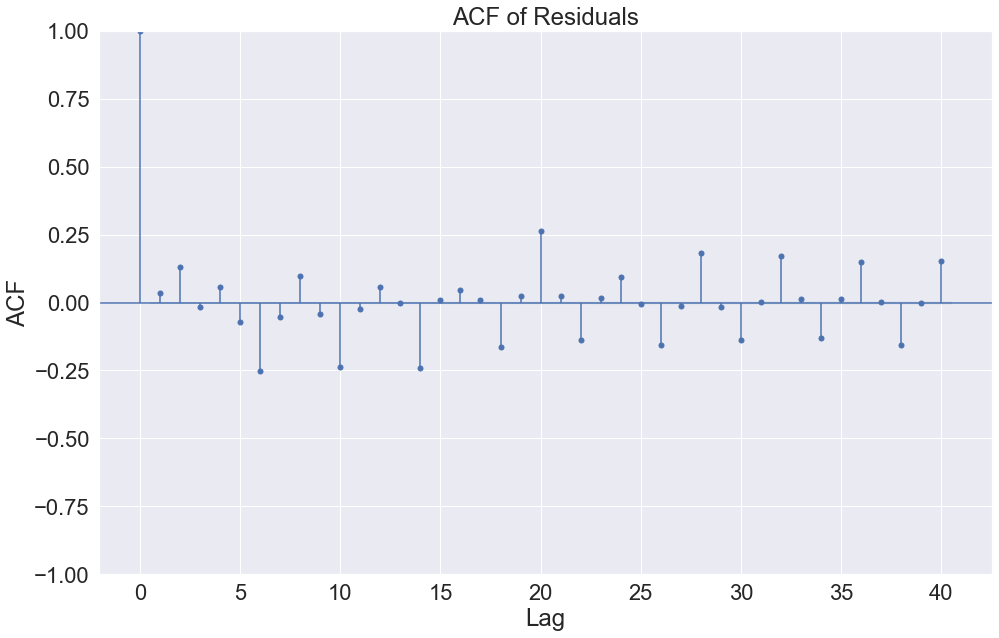

In [210]:
# Residual ACF and PACF plots
plt.figure(figsize=(12, 6))
plot_acf(results.resid, lags=40, alpha=0.05)
plt.title('ACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()



/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x432 with 0 Axes>

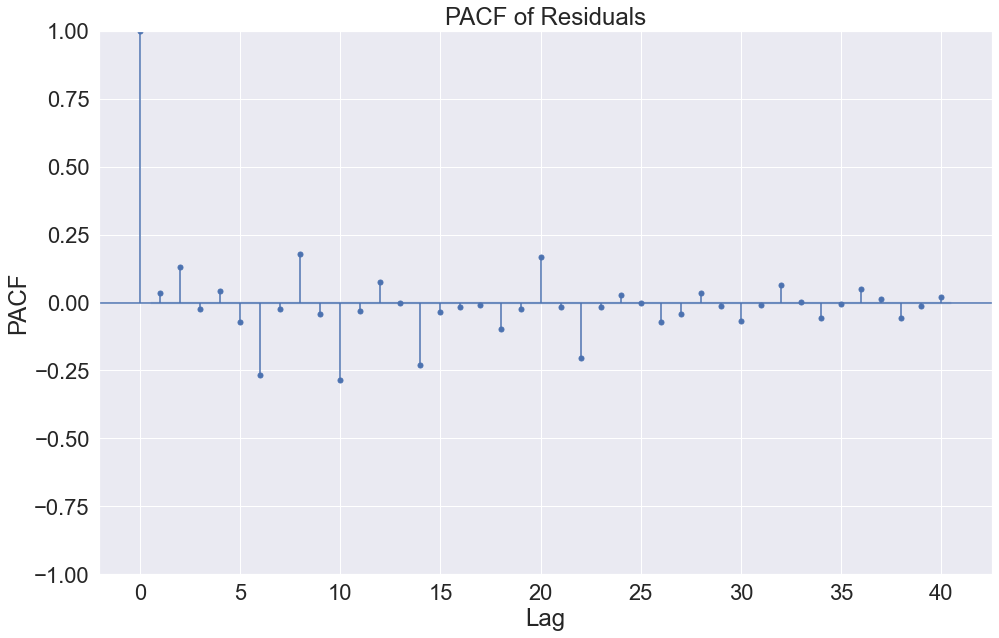

In [211]:
plt.figure(figsize=(12, 6))
plot_pacf(results.resid, lags=40, alpha=0.05)
plt.title('PACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()



In [212]:
# Residual histogram and QQ plot
from scipy.stats import shapiro, probplot

shapiro_test = shapiro(results.resid)
print('Shapiro-Wilk test p-value:', shapiro_test[1])



Shapiro-Wilk test p-value: 7.483881230933158e-161


/var/folders/90/4bx68z_n6bs2_mq1bj8j5_5c0000gn/T/ipykernel_4252/3102239149.py:4: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 277718.
  shapiro_test = shapiro(results.resid)


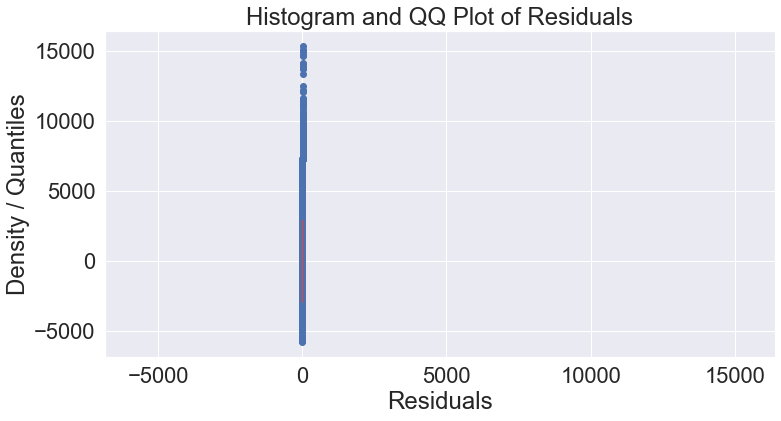

In [213]:
plt.figure(figsize=(12, 6))
plt.hist(results.resid, bins=30, density=True, alpha=0.75)
probplot(results.resid, dist='norm', plot=plt)
plt.title('Histogram and QQ Plot of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density / Quantiles')
plt.grid(True)
plt.show()